In [1]:
# Mixed new and old data

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
#from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import load_model
# Set the random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



def build_unet(input_shape, seed_value=42):
    
    # Create separate input layer
    input_low_geometry = Input(shape=input_shape, name='low_geometry_input')
   
    

    

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(input_low_geometry )
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv5)

    # Expanding path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv9)

    # Velocity output layer
    velocity_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='velocity_output')(conv9)

    # Pressure output layer
    pressure_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='pressure_output')(conv9)

    model = Model(inputs=input_low_geometry, outputs=[pressure_outputs, velocity_outputs])
    return model

def boundary_loss(y_true, y_pred):
    # Extract velocity and pressure from predictions and true values
    velocity_pred = y_pred[0]
    pressure_pred = y_pred[1]
    velocity_true = y_true[0]
    pressure_true = y_true[1]
    
    # Compute max and min values for velocity and pressure
    velocity_pred_max = tf.reduce_max(velocity_pred)
    velocity_pred_min = tf.reduce_min(velocity_pred)
    velocity_true_max = tf.reduce_max(velocity_true)
    velocity_true_min = tf.reduce_min(velocity_true)
    
    pressure_pred_max = tf.reduce_max(pressure_pred)
    pressure_pred_min = tf.reduce_min(pressure_pred)
    pressure_true_max = tf.reduce_max(pressure_true)
    pressure_true_min = tf.reduce_min(pressure_true)
    
    # Compute residuals for max and min values
    velocity_residual = tf.square(velocity_pred_max - velocity_true_max) + tf.square(velocity_pred_min - velocity_true_min)
    pressure_residual = tf.square(pressure_pred_max - pressure_true_max) + tf.square(pressure_pred_min - pressure_true_min)
    
    # Total loss as the sum of residuals
    tloss = (velocity_residual + pressure_residual)/2
    
    return tloss


def data_loss(y_true, y_pred):
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    # Data loss function for velocity and pressure
    d_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return d_loss





def physical_loss(y_true, y_pred):
    
    # Extract velocity and pressure from predictions and true values
    velocity_pred = y_pred[0]
    pressure_pred = y_pred[1]
    velocity_true = y_true[0]
    pressure_true = y_true[1]
    
    
    # Convert the numpy array to a TensorFlow tensor
    velocity_true = tf.convert_to_tensor(velocity_true, dtype=tf.float32)
    pressure_true = tf.convert_to_tensor(pressure_true, dtype=tf.float32)
    
    
    
    velocity_true = tf.expand_dims(velocity_true, axis=-1)
    pressure_true = tf.expand_dims(pressure_true, axis=-1)
    
    velocity_true = tf.expand_dims(velocity_true, axis=0)
    pressure_true = tf.expand_dims(pressure_true, axis=0)
    
    
    velocity_pred = tf.expand_dims(velocity_pred, axis=-1)
    pressure_pred = tf.expand_dims(pressure_pred, axis=-1)

    velocity_pred = tf.expand_dims(velocity_pred, axis=0)
    pressure_pred = tf.expand_dims(pressure_pred, axis=0)

    

    # Compute gradients
    velocity_gradients_pred = tf.image.image_gradients(velocity_pred)
    pressure_gradients_pred = tf.image.image_gradients(pressure_pred)
    velocity_gradients_true = tf.image.image_gradients(velocity_true)
    pressure_gradients_true = tf.image.image_gradients(pressure_true)

    # Compute divergence of velocity (for continuity equation)
    divergence_velocity_pred = velocity_gradients_pred[0] + velocity_gradients_pred[1]
    divergence_velocity_true = velocity_gradients_true[0] + velocity_gradients_true[1]
    
    divergence_pressure_pred = pressure_gradients_pred[0]+ pressure_gradients_pred[1]
    divergence_pressure_true = pressure_gradients_true[0] + pressure_gradients_true[1]


    # Compute the convective term (u · ∇)u for predicted and true velocity
    convective_term_pred = (
        velocity_pred[0] * velocity_gradients_pred[0] + 
        velocity_pred[0] * velocity_gradients_pred[1]
    )
    convective_term_true = (
        velocity_true[0] * velocity_gradients_true[0] + 
        velocity_true[0] * velocity_gradients_true[1]
    )

    # Compute the viscous term μ∇²u (Laplacian of velocity) for predicted and true velocity
    viscous_term_pred =  (
        tf.image.image_gradients(velocity_gradients_pred[0]) + 
        tf.image.image_gradients(velocity_gradients_pred[1])
    )
    viscous_term_true =  (
        tf.image.image_gradients(velocity_gradients_true[0]) + 
        tf.image.image_gradients(velocity_gradients_true[1])
    )

    # Compute the pressure gradient term ∇p for predicted and true pressure
    pressure_gradient_pred = tf.concat(pressure_gradients_pred, axis=-1)
    pressure_gradient_true = tf.concat(pressure_gradients_true, axis=-1)

    # Compute the momentum residual for predicted and true values
    momentum_residual_pred = (
        convective_term_pred - 
        pressure_gradient_pred + 
        viscous_term_pred
    )
    momentum_residual_true = (
        convective_term_true - 
        pressure_gradient_true + 
        viscous_term_true
    )
    
    
    
    

    # Compute the L2 norm of the momentum residual
    momentum_residual_norm = tf.reduce_mean(tf.square(momentum_residual_pred - momentum_residual_true))

    # Compute the L2 norm of the continuity residual
    continuity_residual_norm = tf.reduce_mean(tf.square(divergence_velocity_pred - divergence_velocity_true))

    # Total physical loss is the sum of momentum and continuity residuals
    physical_loss_value = 0.2*momentum_residual_norm +continuity_residual_norm

    return physical_loss_value

    
    



def total_loss(y_true, y_pred):
    # You can customize the weighting of the data loss and physical loss here
    weight_boundary_loss = 0.02
    weight_data_loss = 0.08
    weight_physical_loss = 0.9
    phy=physical_loss(y_true, y_pred)

    # Calculate the total loss as a combination of data loss and physical loss
    total_loss = (weight_data_loss * data_loss(y_true, y_pred) )+(weight_physical_loss * phy ) + (weight_boundary_loss * boundary_loss(y_true, y_pred) )
    return total_loss
     






# Train the model with your dataset
import os
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint







hv_folder = 'High/HVV'
hp_folder = 'High/HPP'
lg_folder = 'LG-3C2'



# Get the list of file names in each folder

hv_files = [f for f in os.listdir(hv_folder) if f != ".ipynb_checkpoints"]
hp_files = [f for f in os.listdir(hp_folder) if f != ".ipynb_checkpoints"]
lg_files = [f for f in os.listdir(lg_folder) if f != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent

hv_files.sort()
hp_files.sort()
lg_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images

# Create empty lists to store the data

X_lg = []
Y_hv = []
Y_hp = []

# Read the data from the folders
for hv_file,hp_file,lg_file in zip( hv_files,hp_files,lg_files):
    try:
        
        
        # Read the HFV
        hv_image = np.load(os.path.join(hv_folder, hv_file))  # Convert to RGB
        Y_hv.append(np.array(hv_image))

    
    
        # Read the channel geometry image
        lg_image = Image.open(os.path.join(lg_folder, lg_file)).convert('RGB')  # Convert to RGB
        lg_image = lg_image.resize(input_shape[:2])  # Resize the image
        X_lg.append(np.array(lg_image))
    
        # Read the HFP
        hp_image = np.load(os.path.join(hp_folder, hp_file))  # Convert to RGB
        Y_hp.append(np.array(hp_image))
    except:
        print('')

# Convert the lists to arrays
X_lg = np.array(X_lg) / 255.0  # Normalize the channel geometry images
Y_hv = np.array(Y_hv)
Y_hp = np.array(Y_hp)

Y_hpt=(Y_hp-np.min(Y_hp))/(np.max(Y_hp)-np.min(Y_hp))






# Build the U-Net model
model = build_unet(input_shape)


optim = Adam(learning_rate=0.00001)
# Compile the model with the desired loss functions
model.compile(optimizer=optim,
              loss=[total_loss,total_loss])
# Set up checkpoints to save the best model during training
checkpoint_path = 'Saved_Models_Temp/total-Micro-Unet-Zero.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Train the model
epochs = 2400
batch_size = 16
print('start fitting')
model.fit(X_lg, [Y_hpt, Y_hv],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[checkpoint])





2025-01-04 19:12:05.671165: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-01-04 19:12:05.671185: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2025-01-04 19:12:05.671194: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2025-01-04 19:12:05.671224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-04 19:12:05.671237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


start fitting
Epoch 1/2400


2025-01-04 19:12:08.396395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.0235 - pressure_output_loss: 0.0088 - velocity_output_loss: 0.0148

2025-01-04 19:13:22.459523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00546, saving model to Saved_Models/total-Micro-Unet-Zero.h5


/Users/trina-mrd-lab2/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - 81s 561ms/step - loss: 0.0235 - pressure_output_loss: 0.0088 - velocity_output_loss: 0.0148 - val_loss: 0.0055 - val_pressure_output_loss: 0.0025 - val_velocity_output_loss: 0.0029
Epoch 2/2400
142/142 [==============================] - ETA: 0s - loss: 0.0034 - pressure_output_loss: 0.0019 - velocity_output_loss: 0.0014
Epoch 2: val_loss improved from 0.00546 to 0.00300, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 79s 553ms/step - loss: 0.0034 - pressure_output_loss: 0.0019 - velocity_output_loss: 0.0014 - val_loss: 0.0030 - val_pressure_output_loss: 0.0013 - val_velocity_output_loss: 0.0017
Epoch 3/2400
142/142 [==============================] - ETA: 0s - loss: 0.0018 - pressure_output_loss: 9.4593e-04 - velocity_output_loss: 8.3844e-04
Epoch 3: val_loss improved from 0.00300 to 0.00141, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 78s 552

142/142 [==============================] - 85s 598ms/step - loss: 8.0087e-04 - pressure_output_loss: 2.6480e-04 - velocity_output_loss: 5.3607e-04 - val_loss: 4.6727e-04 - val_pressure_output_loss: 2.2890e-04 - val_velocity_output_loss: 2.3837e-04
Epoch 19/2400
142/142 [==============================] - ETA: 0s - loss: 7.7132e-04 - pressure_output_loss: 2.6683e-04 - velocity_output_loss: 5.0449e-04
Epoch 19: val_loss improved from 0.00047 to 0.00035, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 609ms/step - loss: 7.7132e-04 - pressure_output_loss: 2.6683e-04 - velocity_output_loss: 5.0449e-04 - val_loss: 3.4545e-04 - val_pressure_output_loss: 2.1562e-04 - val_velocity_output_loss: 1.2984e-04
Epoch 20/2400
142/142 [==============================] - ETA: 0s - loss: 7.2713e-04 - pressure_output_loss: 2.5452e-04 - velocity_output_loss: 4.7261e-04
Epoch 20: val_loss improved from 0.00035 to 0.00031, saving model to Saved_Models/total-M

Epoch 36/2400
142/142 [==============================] - ETA: 0s - loss: 6.6334e-04 - pressure_output_loss: 2.0454e-04 - velocity_output_loss: 4.5880e-04
Epoch 36: val_loss improved from 0.00025 to 0.00024, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 606ms/step - loss: 6.6334e-04 - pressure_output_loss: 2.0454e-04 - velocity_output_loss: 4.5880e-04 - val_loss: 2.4287e-04 - val_pressure_output_loss: 1.6765e-04 - val_velocity_output_loss: 7.5212e-05
Epoch 37/2400
142/142 [==============================] - ETA: 0s - loss: 6.4491e-04 - pressure_output_loss: 1.9366e-04 - velocity_output_loss: 4.5125e-04
Epoch 37: val_loss did not improve from 0.00024
142/142 [==============================] - 87s 614ms/step - loss: 6.4491e-04 - pressure_output_loss: 1.9366e-04 - velocity_output_loss: 4.5125e-04 - val_loss: 2.6234e-04 - val_pressure_output_loss: 1.7709e-04 - val_velocity_output_loss: 8.5249e-05
Epoch 38/2400
142/142 [==================

142/142 [==============================] - 87s 613ms/step - loss: 5.1480e-04 - pressure_output_loss: 1.2122e-04 - velocity_output_loss: 3.9358e-04 - val_loss: 2.1784e-04 - val_pressure_output_loss: 1.4509e-04 - val_velocity_output_loss: 7.2757e-05
Epoch 54/2400
142/142 [==============================] - ETA: 0s - loss: 5.6313e-04 - pressure_output_loss: 1.4147e-04 - velocity_output_loss: 4.2166e-04
Epoch 54: val_loss did not improve from 0.00022
142/142 [==============================] - 88s 619ms/step - loss: 5.6313e-04 - pressure_output_loss: 1.4147e-04 - velocity_output_loss: 4.2166e-04 - val_loss: 2.2079e-04 - val_pressure_output_loss: 1.5012e-04 - val_velocity_output_loss: 7.0674e-05
Epoch 55/2400
142/142 [==============================] - ETA: 0s - loss: 5.3800e-04 - pressure_output_loss: 1.3175e-04 - velocity_output_loss: 4.0625e-04
Epoch 55: val_loss did not improve from 0.00022
142/142 [==============================] - 90s 635ms/step - loss: 5.3800e-04 - pressure_output_loss:

Epoch 71/2400
142/142 [==============================] - ETA: 0s - loss: 4.5536e-04 - pressure_output_loss: 9.8303e-05 - velocity_output_loss: 3.5706e-04
Epoch 71: val_loss did not improve from 0.00018
142/142 [==============================] - 85s 601ms/step - loss: 4.5536e-04 - pressure_output_loss: 9.8303e-05 - velocity_output_loss: 3.5706e-04 - val_loss: 1.8353e-04 - val_pressure_output_loss: 1.0324e-04 - val_velocity_output_loss: 8.0285e-05
Epoch 72/2400
142/142 [==============================] - ETA: 0s - loss: 4.9582e-04 - pressure_output_loss: 1.0370e-04 - velocity_output_loss: 3.9212e-04
Epoch 72: val_loss did not improve from 0.00018
142/142 [==============================] - 86s 607ms/step - loss: 4.9582e-04 - pressure_output_loss: 1.0370e-04 - velocity_output_loss: 3.9212e-04 - val_loss: 1.8871e-04 - val_pressure_output_loss: 1.1820e-04 - val_velocity_output_loss: 7.0512e-05
Epoch 73/2400
142/142 [==============================] - ETA: 0s - loss: 4.7318e-04 - pressure_outpu

142/142 [==============================] - 85s 602ms/step - loss: 4.5853e-04 - pressure_output_loss: 7.9491e-05 - velocity_output_loss: 3.7904e-04 - val_loss: 1.4347e-04 - val_pressure_output_loss: 7.5660e-05 - val_velocity_output_loss: 6.7812e-05
Epoch 89/2400
142/142 [==============================] - ETA: 0s - loss: 4.2979e-04 - pressure_output_loss: 7.6760e-05 - velocity_output_loss: 3.5303e-04
Epoch 89: val_loss did not improve from 0.00014
142/142 [==============================] - 84s 594ms/step - loss: 4.2979e-04 - pressure_output_loss: 7.6760e-05 - velocity_output_loss: 3.5303e-04 - val_loss: 1.5088e-04 - val_pressure_output_loss: 7.7093e-05 - val_velocity_output_loss: 7.3786e-05
Epoch 90/2400
142/142 [==============================] - ETA: 0s - loss: 7.9526e-04 - pressure_output_loss: 3.5374e-04 - velocity_output_loss: 4.4152e-04
Epoch 90: val_loss did not improve from 0.00014
142/142 [==============================] - 85s 597ms/step - loss: 7.9526e-04 - pressure_output_loss:

Epoch 106/2400
142/142 [==============================] - ETA: 0s - loss: 7.6645e-04 - pressure_output_loss: 3.3785e-04 - velocity_output_loss: 4.2859e-04
Epoch 106: val_loss improved from 0.00012 to 0.00012, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 603ms/step - loss: 7.6645e-04 - pressure_output_loss: 3.3785e-04 - velocity_output_loss: 4.2859e-04 - val_loss: 1.1533e-04 - val_pressure_output_loss: 5.3636e-05 - val_velocity_output_loss: 6.1690e-05
Epoch 107/2400
142/142 [==============================] - ETA: 0s - loss: 6.8122e-04 - pressure_output_loss: 2.9653e-04 - velocity_output_loss: 3.8470e-04
Epoch 107: val_loss did not improve from 0.00012
142/142 [==============================] - 85s 596ms/step - loss: 6.8122e-04 - pressure_output_loss: 2.9653e-04 - velocity_output_loss: 3.8470e-04 - val_loss: 1.2379e-04 - val_pressure_output_loss: 5.5966e-05 - val_velocity_output_loss: 6.7826e-05
Epoch 108/2400
142/142 [=============

Epoch 141/2400
142/142 [==============================] - ETA: 0s - loss: 3.7928e-04 - pressure_output_loss: 5.4657e-05 - velocity_output_loss: 3.2462e-04
Epoch 141: val_loss improved from 0.00009 to 0.00009, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 607ms/step - loss: 3.7928e-04 - pressure_output_loss: 5.4657e-05 - velocity_output_loss: 3.2462e-04 - val_loss: 8.8974e-05 - val_pressure_output_loss: 2.9582e-05 - val_velocity_output_loss: 5.9392e-05
Epoch 142/2400
142/142 [==============================] - ETA: 0s - loss: 3.9649e-04 - pressure_output_loss: 6.3050e-05 - velocity_output_loss: 3.3344e-04
Epoch 142: val_loss did not improve from 0.00009
142/142 [==============================] - 86s 606ms/step - loss: 3.9649e-04 - pressure_output_loss: 6.3050e-05 - velocity_output_loss: 3.3344e-04 - val_loss: 9.0917e-05 - val_pressure_output_loss: 3.4079e-05 - val_velocity_output_loss: 5.6838e-05
Epoch 143/2400
142/142 [=============

Epoch 159/2400
142/142 [==============================] - ETA: 0s - loss: 3.8337e-04 - pressure_output_loss: 6.0690e-05 - velocity_output_loss: 3.2268e-04
Epoch 159: val_loss did not improve from 0.00008
142/142 [==============================] - 85s 599ms/step - loss: 3.8337e-04 - pressure_output_loss: 6.0690e-05 - velocity_output_loss: 3.2268e-04 - val_loss: 8.2966e-05 - val_pressure_output_loss: 2.9321e-05 - val_velocity_output_loss: 5.3645e-05
Epoch 160/2400
142/142 [==============================] - ETA: 0s - loss: 3.4302e-04 - pressure_output_loss: 5.7993e-05 - velocity_output_loss: 2.8502e-04
Epoch 160: val_loss did not improve from 0.00008
142/142 [==============================] - 85s 600ms/step - loss: 3.4302e-04 - pressure_output_loss: 5.7993e-05 - velocity_output_loss: 2.8502e-04 - val_loss: 8.4311e-05 - val_pressure_output_loss: 3.1190e-05 - val_velocity_output_loss: 5.3120e-05
Epoch 161/2400
142/142 [==============================] - ETA: 0s - loss: 3.8493e-04 - pressure_

Epoch 177/2400
142/142 [==============================] - ETA: 0s - loss: 3.4787e-04 - pressure_output_loss: 6.4956e-05 - velocity_output_loss: 2.8291e-04
Epoch 177: val_loss did not improve from 0.00007
142/142 [==============================] - 87s 614ms/step - loss: 3.4787e-04 - pressure_output_loss: 6.4956e-05 - velocity_output_loss: 2.8291e-04 - val_loss: 8.6020e-05 - val_pressure_output_loss: 2.8995e-05 - val_velocity_output_loss: 5.7025e-05
Epoch 178/2400
142/142 [==============================] - ETA: 0s - loss: 3.5563e-04 - pressure_output_loss: 6.0918e-05 - velocity_output_loss: 2.9471e-04
Epoch 178: val_loss did not improve from 0.00007
142/142 [==============================] - 86s 604ms/step - loss: 3.5563e-04 - pressure_output_loss: 6.0918e-05 - velocity_output_loss: 2.9471e-04 - val_loss: 8.1232e-05 - val_pressure_output_loss: 3.1416e-05 - val_velocity_output_loss: 4.9816e-05
Epoch 179/2400
142/142 [==============================] - ETA: 0s - loss: 3.7683e-04 - pressure_

Epoch 195/2400
142/142 [==============================] - ETA: 0s - loss: 3.6159e-04 - pressure_output_loss: 6.4836e-05 - velocity_output_loss: 2.9675e-04
Epoch 195: val_loss did not improve from 0.00007
142/142 [==============================] - 88s 619ms/step - loss: 3.6159e-04 - pressure_output_loss: 6.4836e-05 - velocity_output_loss: 2.9675e-04 - val_loss: 7.8839e-05 - val_pressure_output_loss: 2.7248e-05 - val_velocity_output_loss: 5.1591e-05
Epoch 196/2400
142/142 [==============================] - ETA: 0s - loss: 3.7117e-04 - pressure_output_loss: 6.1321e-05 - velocity_output_loss: 3.0985e-04
Epoch 196: val_loss did not improve from 0.00007
142/142 [==============================] - 88s 619ms/step - loss: 3.7117e-04 - pressure_output_loss: 6.1321e-05 - velocity_output_loss: 3.0985e-04 - val_loss: 6.9087e-05 - val_pressure_output_loss: 2.2221e-05 - val_velocity_output_loss: 4.6865e-05
Epoch 197/2400
142/142 [==============================] - ETA: 0s - loss: 3.4135e-04 - pressure_

Epoch 213/2400
142/142 [==============================] - ETA: 0s - loss: 5.5477e-04 - pressure_output_loss: 2.3641e-04 - velocity_output_loss: 3.1836e-04
Epoch 213: val_loss did not improve from 0.00007
142/142 [==============================] - 88s 622ms/step - loss: 5.5477e-04 - pressure_output_loss: 2.3641e-04 - velocity_output_loss: 3.1836e-04 - val_loss: 9.3168e-05 - val_pressure_output_loss: 3.8683e-05 - val_velocity_output_loss: 5.4485e-05
Epoch 214/2400
142/142 [==============================] - ETA: 0s - loss: 4.8191e-04 - pressure_output_loss: 1.1618e-04 - velocity_output_loss: 3.6574e-04
Epoch 214: val_loss did not improve from 0.00007
142/142 [==============================] - 88s 619ms/step - loss: 4.8191e-04 - pressure_output_loss: 1.1618e-04 - velocity_output_loss: 3.6574e-04 - val_loss: 1.0751e-04 - val_pressure_output_loss: 4.0769e-05 - val_velocity_output_loss: 6.6742e-05
Epoch 215/2400
142/142 [==============================] - ETA: 0s - loss: 3.9804e-04 - pressure_

142/142 [==============================] - ETA: 0s - loss: 3.3631e-04 - pressure_output_loss: 5.1298e-05 - velocity_output_loss: 2.8501e-04
Epoch 249: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 603ms/step - loss: 3.3631e-04 - pressure_output_loss: 5.1298e-05 - velocity_output_loss: 2.8501e-04 - val_loss: 6.5483e-05 - val_pressure_output_loss: 2.1643e-05 - val_velocity_output_loss: 4.3840e-05
Epoch 250/2400
142/142 [==============================] - ETA: 0s - loss: 3.0504e-04 - pressure_output_loss: 4.5455e-05 - velocity_output_loss: 2.5958e-04
Epoch 250: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 605ms/step - loss: 3.0504e-04 - pressure_output_loss: 4.5455e-05 - velocity_output_loss: 2.5958e-04 - val_loss: 6.6230e-05 - val_pressure_output_loss: 2.1574e-05 - val_velocity_output_loss: 4.4656e-05
Epoch 251/2400
142/142 [==============================] - ETA: 0s - loss: 4.0366e-04 - pressure_output_loss: 1.

Epoch 267/2400
142/142 [==============================] - ETA: 0s - loss: 3.4750e-04 - pressure_output_loss: 4.8891e-05 - velocity_output_loss: 2.9861e-04
Epoch 267: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 608ms/step - loss: 3.4750e-04 - pressure_output_loss: 4.8891e-05 - velocity_output_loss: 2.9861e-04 - val_loss: 7.0735e-05 - val_pressure_output_loss: 2.5203e-05 - val_velocity_output_loss: 4.5532e-05
Epoch 268/2400
142/142 [==============================] - ETA: 0s - loss: 3.1667e-04 - pressure_output_loss: 4.7293e-05 - velocity_output_loss: 2.6938e-04
Epoch 268: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 608ms/step - loss: 3.1667e-04 - pressure_output_loss: 4.7293e-05 - velocity_output_loss: 2.6938e-04 - val_loss: 6.1619e-05 - val_pressure_output_loss: 1.8198e-05 - val_velocity_output_loss: 4.3421e-05
Epoch 269/2400
142/142 [==============================] - ETA: 0s - loss: 3.1688e-04 - pressure_

Epoch 285/2400
142/142 [==============================] - ETA: 0s - loss: 3.7878e-04 - pressure_output_loss: 8.4784e-05 - velocity_output_loss: 2.9399e-04
Epoch 285: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 608ms/step - loss: 3.7878e-04 - pressure_output_loss: 8.4784e-05 - velocity_output_loss: 2.9399e-04 - val_loss: 6.1170e-05 - val_pressure_output_loss: 1.7990e-05 - val_velocity_output_loss: 4.3180e-05
Epoch 286/2400
142/142 [==============================] - ETA: 0s - loss: 2.8379e-04 - pressure_output_loss: 3.7351e-05 - velocity_output_loss: 2.4644e-04
Epoch 286: val_loss did not improve from 0.00006
142/142 [==============================] - 87s 610ms/step - loss: 2.8379e-04 - pressure_output_loss: 3.7351e-05 - velocity_output_loss: 2.4644e-04 - val_loss: 6.4323e-05 - val_pressure_output_loss: 2.1004e-05 - val_velocity_output_loss: 4.3319e-05
Epoch 287/2400
142/142 [==============================] - ETA: 0s - loss: 3.0077e-04 - pressure_

Epoch 303/2400
142/142 [==============================] - ETA: 0s - loss: 2.9075e-04 - pressure_output_loss: 4.2073e-05 - velocity_output_loss: 2.4868e-04
Epoch 303: val_loss did not improve from 0.00006
142/142 [==============================] - 86s 609ms/step - loss: 2.9075e-04 - pressure_output_loss: 4.2073e-05 - velocity_output_loss: 2.4868e-04 - val_loss: 6.2618e-05 - val_pressure_output_loss: 2.0398e-05 - val_velocity_output_loss: 4.2219e-05
Epoch 304/2400
142/142 [==============================] - ETA: 0s - loss: 2.8579e-04 - pressure_output_loss: 4.4162e-05 - velocity_output_loss: 2.4162e-04
Epoch 304: val_loss improved from 0.00006 to 0.00006, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 610ms/step - loss: 2.8579e-04 - pressure_output_loss: 4.4162e-05 - velocity_output_loss: 2.4162e-04 - val_loss: 5.6845e-05 - val_pressure_output_loss: 1.7296e-05 - val_velocity_output_loss: 3.9550e-05
Epoch 305/2400
142/142 [=============

Epoch 321/2400
142/142 [==============================] - ETA: 0s - loss: 2.7799e-04 - pressure_output_loss: 4.0506e-05 - velocity_output_loss: 2.3748e-04
Epoch 321: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 603ms/step - loss: 2.7799e-04 - pressure_output_loss: 4.0506e-05 - velocity_output_loss: 2.3748e-04 - val_loss: 5.7634e-05 - val_pressure_output_loss: 1.9089e-05 - val_velocity_output_loss: 3.8545e-05
Epoch 322/2400
142/142 [==============================] - ETA: 0s - loss: 3.2657e-04 - pressure_output_loss: 8.9140e-05 - velocity_output_loss: 2.3743e-04
Epoch 322: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 605ms/step - loss: 3.2657e-04 - pressure_output_loss: 8.9140e-05 - velocity_output_loss: 2.3743e-04 - val_loss: 8.0443e-05 - val_pressure_output_loss: 2.7273e-05 - val_velocity_output_loss: 5.3170e-05
Epoch 323/2400
142/142 [==============================] - ETA: 0s - loss: 2.7480e-04 - pressure_

142/142 [==============================] - 87s 610ms/step - loss: 2.2944e-04 - pressure_output_loss: 3.5997e-05 - velocity_output_loss: 1.9344e-04 - val_loss: 5.1815e-05 - val_pressure_output_loss: 1.5239e-05 - val_velocity_output_loss: 3.6575e-05
Epoch 339/2400
142/142 [==============================] - ETA: 0s - loss: 3.0385e-04 - pressure_output_loss: 7.8885e-05 - velocity_output_loss: 2.2497e-04
Epoch 339: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 604ms/step - loss: 3.0385e-04 - pressure_output_loss: 7.8885e-05 - velocity_output_loss: 2.2497e-04 - val_loss: 1.1853e-04 - val_pressure_output_loss: 7.2469e-05 - val_velocity_output_loss: 4.6060e-05
Epoch 340/2400
142/142 [==============================] - ETA: 0s - loss: 4.8664e-04 - pressure_output_loss: 2.4142e-04 - velocity_output_loss: 2.4521e-04
Epoch 340: val_loss did not improve from 0.00005
142/142 [==============================] - 85s 601ms/step - loss: 4.8664e-04 - pressure_output_l

142/142 [==============================] - ETA: 0s - loss: 2.4190e-04 - pressure_output_loss: 4.1502e-05 - velocity_output_loss: 2.0040e-04
Epoch 374: val_loss did not improve from 0.00005
142/142 [==============================] - 87s 614ms/step - loss: 2.4190e-04 - pressure_output_loss: 4.1502e-05 - velocity_output_loss: 2.0040e-04 - val_loss: 5.1723e-05 - val_pressure_output_loss: 1.6560e-05 - val_velocity_output_loss: 3.5162e-05
Epoch 375/2400
142/142 [==============================] - ETA: 0s - loss: 2.2679e-04 - pressure_output_loss: 3.2495e-05 - velocity_output_loss: 1.9430e-04
Epoch 375: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 608ms/step - loss: 2.2679e-04 - pressure_output_loss: 3.2495e-05 - velocity_output_loss: 1.9430e-04 - val_loss: 5.3725e-05 - val_pressure_output_loss: 1.5906e-05 - val_velocity_output_loss: 3.7819e-05
Epoch 376/2400
142/142 [==============================] - ETA: 0s - loss: 2.4876e-04 - pressure_output_loss: 4.

Epoch 392/2400
142/142 [==============================] - ETA: 0s - loss: 2.2658e-04 - pressure_output_loss: 3.5944e-05 - velocity_output_loss: 1.9064e-04
Epoch 392: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 609ms/step - loss: 2.2658e-04 - pressure_output_loss: 3.5944e-05 - velocity_output_loss: 1.9064e-04 - val_loss: 4.6867e-05 - val_pressure_output_loss: 1.4483e-05 - val_velocity_output_loss: 3.2385e-05
Epoch 393/2400
142/142 [==============================] - ETA: 0s - loss: 2.2759e-04 - pressure_output_loss: 3.5755e-05 - velocity_output_loss: 1.9183e-04
Epoch 393: val_loss did not improve from 0.00005
142/142 [==============================] - 86s 605ms/step - loss: 2.2759e-04 - pressure_output_loss: 3.5755e-05 - velocity_output_loss: 1.9183e-04 - val_loss: 6.1764e-05 - val_pressure_output_loss: 2.2432e-05 - val_velocity_output_loss: 3.9331e-05
Epoch 394/2400
142/142 [==============================] - ETA: 0s - loss: 3.9027e-04 - pressure_

Epoch 428/2400
142/142 [==============================] - ETA: 0s - loss: 2.1716e-04 - pressure_output_loss: 3.2214e-05 - velocity_output_loss: 1.8495e-04
Epoch 428: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 605ms/step - loss: 2.1716e-04 - pressure_output_loss: 3.2214e-05 - velocity_output_loss: 1.8495e-04 - val_loss: 4.4576e-05 - val_pressure_output_loss: 1.5805e-05 - val_velocity_output_loss: 2.8771e-05
Epoch 429/2400
142/142 [==============================] - ETA: 0s - loss: 2.2967e-04 - pressure_output_loss: 3.9356e-05 - velocity_output_loss: 1.9031e-04
Epoch 429: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 2.2967e-04 - pressure_output_loss: 3.9356e-05 - velocity_output_loss: 1.9031e-04 - val_loss: 4.5364e-05 - val_pressure_output_loss: 1.3109e-05 - val_velocity_output_loss: 3.2255e-05
Epoch 430/2400
142/142 [==============================] - ETA: 0s - loss: 2.5485e-04 - pressure_

Epoch 464/2400
142/142 [==============================] - ETA: 0s - loss: 2.0379e-04 - pressure_output_loss: 3.4382e-05 - velocity_output_loss: 1.6941e-04
Epoch 464: val_loss did not improve from 0.00004
142/142 [==============================] - 86s 604ms/step - loss: 2.0379e-04 - pressure_output_loss: 3.4382e-05 - velocity_output_loss: 1.6941e-04 - val_loss: 4.1123e-05 - val_pressure_output_loss: 1.2686e-05 - val_velocity_output_loss: 2.8437e-05
Epoch 465/2400
142/142 [==============================] - ETA: 0s - loss: 1.8515e-04 - pressure_output_loss: 3.1841e-05 - velocity_output_loss: 1.5331e-04
Epoch 465: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 602ms/step - loss: 1.8515e-04 - pressure_output_loss: 3.1841e-05 - velocity_output_loss: 1.5331e-04 - val_loss: 4.9078e-05 - val_pressure_output_loss: 2.0394e-05 - val_velocity_output_loss: 2.8684e-05
Epoch 466/2400
142/142 [==============================] - ETA: 0s - loss: 2.4405e-04 - pressure_

Epoch 482/2400
142/142 [==============================] - ETA: 0s - loss: 1.9575e-04 - pressure_output_loss: 3.4180e-05 - velocity_output_loss: 1.6157e-04
Epoch 482: val_loss improved from 0.00004 to 0.00004, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 605ms/step - loss: 1.9575e-04 - pressure_output_loss: 3.4180e-05 - velocity_output_loss: 1.6157e-04 - val_loss: 3.6856e-05 - val_pressure_output_loss: 1.2118e-05 - val_velocity_output_loss: 2.4738e-05
Epoch 483/2400
142/142 [==============================] - ETA: 0s - loss: 2.0841e-04 - pressure_output_loss: 4.1043e-05 - velocity_output_loss: 1.6737e-04
Epoch 483: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 601ms/step - loss: 2.0841e-04 - pressure_output_loss: 4.1043e-05 - velocity_output_loss: 1.6737e-04 - val_loss: 4.1735e-05 - val_pressure_output_loss: 1.4227e-05 - val_velocity_output_loss: 2.7508e-05
Epoch 484/2400
142/142 [=============

Epoch 500/2400
142/142 [==============================] - ETA: 0s - loss: 1.7628e-04 - pressure_output_loss: 2.9720e-05 - velocity_output_loss: 1.4656e-04
Epoch 500: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 1.7628e-04 - pressure_output_loss: 2.9720e-05 - velocity_output_loss: 1.4656e-04 - val_loss: 3.7214e-05 - val_pressure_output_loss: 1.2580e-05 - val_velocity_output_loss: 2.4634e-05
Epoch 501/2400
142/142 [==============================] - ETA: 0s - loss: 2.4304e-04 - pressure_output_loss: 7.3977e-05 - velocity_output_loss: 1.6906e-04
Epoch 501: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 602ms/step - loss: 2.4304e-04 - pressure_output_loss: 7.3977e-05 - velocity_output_loss: 1.6906e-04 - val_loss: 4.0431e-05 - val_pressure_output_loss: 1.3004e-05 - val_velocity_output_loss: 2.7427e-05
Epoch 502/2400
142/142 [==============================] - ETA: 0s - loss: 2.0108e-04 - pressure_

Epoch 536/2400
142/142 [==============================] - ETA: 0s - loss: 1.9637e-04 - pressure_output_loss: 3.9021e-05 - velocity_output_loss: 1.5735e-04
Epoch 536: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 601ms/step - loss: 1.9637e-04 - pressure_output_loss: 3.9021e-05 - velocity_output_loss: 1.5735e-04 - val_loss: 3.8586e-05 - val_pressure_output_loss: 1.4376e-05 - val_velocity_output_loss: 2.4210e-05
Epoch 537/2400
142/142 [==============================] - ETA: 0s - loss: 1.7220e-04 - pressure_output_loss: 2.9648e-05 - velocity_output_loss: 1.4255e-04
Epoch 537: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 599ms/step - loss: 1.7220e-04 - pressure_output_loss: 2.9648e-05 - velocity_output_loss: 1.4255e-04 - val_loss: 3.6059e-05 - val_pressure_output_loss: 1.1536e-05 - val_velocity_output_loss: 2.4523e-05
Epoch 538/2400
142/142 [==============================] - ETA: 0s - loss: 1.6058e-04 - pressure_

Epoch 554/2400
142/142 [==============================] - ETA: 0s - loss: 1.6733e-04 - pressure_output_loss: 2.8073e-05 - velocity_output_loss: 1.3926e-04
Epoch 554: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 602ms/step - loss: 1.6733e-04 - pressure_output_loss: 2.8073e-05 - velocity_output_loss: 1.3926e-04 - val_loss: 3.5140e-05 - val_pressure_output_loss: 1.2136e-05 - val_velocity_output_loss: 2.3004e-05
Epoch 555/2400
142/142 [==============================] - ETA: 0s - loss: 1.7014e-04 - pressure_output_loss: 2.8687e-05 - velocity_output_loss: 1.4145e-04
Epoch 555: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 85s 602ms/step - loss: 1.7014e-04 - pressure_output_loss: 2.8687e-05 - velocity_output_loss: 1.4145e-04 - val_loss: 3.2582e-05 - val_pressure_output_loss: 1.0130e-05 - val_velocity_output_loss: 2.2453e-05
Epoch 556/2400
142/142 [=============

Epoch 572/2400
142/142 [==============================] - ETA: 0s - loss: 1.7844e-04 - pressure_output_loss: 3.0869e-05 - velocity_output_loss: 1.4757e-04
Epoch 572: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 599ms/step - loss: 1.7844e-04 - pressure_output_loss: 3.0869e-05 - velocity_output_loss: 1.4757e-04 - val_loss: 4.0679e-05 - val_pressure_output_loss: 1.6828e-05 - val_velocity_output_loss: 2.3852e-05
Epoch 573/2400
142/142 [==============================] - ETA: 0s - loss: 1.6817e-04 - pressure_output_loss: 3.2527e-05 - velocity_output_loss: 1.3564e-04
Epoch 573: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 599ms/step - loss: 1.6817e-04 - pressure_output_loss: 3.2527e-05 - velocity_output_loss: 1.3564e-04 - val_loss: 3.3724e-05 - val_pressure_output_loss: 1.1692e-05 - val_velocity_output_loss: 2.2032e-05
Epoch 574/2400
142/142 [==============================] - ETA: 0s - loss: 1.7694e-04 - pressure_

Epoch 590/2400
142/142 [==============================] - ETA: 0s - loss: 1.7368e-04 - pressure_output_loss: 3.1252e-05 - velocity_output_loss: 1.4243e-04
Epoch 590: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 602ms/step - loss: 1.7368e-04 - pressure_output_loss: 3.1252e-05 - velocity_output_loss: 1.4243e-04 - val_loss: 4.2139e-05 - val_pressure_output_loss: 1.8796e-05 - val_velocity_output_loss: 2.3343e-05
Epoch 591/2400
142/142 [==============================] - ETA: 0s - loss: 1.4771e-04 - pressure_output_loss: 2.8439e-05 - velocity_output_loss: 1.1927e-04
Epoch 591: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 602ms/step - loss: 1.4771e-04 - pressure_output_loss: 2.8439e-05 - velocity_output_loss: 1.1927e-04 - val_loss: 3.2299e-05 - val_pressure_output_loss: 1.0427e-05 - val_velocity_output_loss: 2.1872e-05
Epoch 592/2400
142/142 [==============================] - ETA: 0s - loss: 1.5927e-04 - pressure_

Epoch 608/2400
142/142 [==============================] - ETA: 0s - loss: 1.5149e-04 - pressure_output_loss: 2.7008e-05 - velocity_output_loss: 1.2448e-04
Epoch 608: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 607ms/step - loss: 1.5149e-04 - pressure_output_loss: 2.7008e-05 - velocity_output_loss: 1.2448e-04 - val_loss: 3.1496e-05 - val_pressure_output_loss: 1.0413e-05 - val_velocity_output_loss: 2.1082e-05
Epoch 609/2400
142/142 [==============================] - ETA: 0s - loss: 1.5292e-04 - pressure_output_loss: 2.6519e-05 - velocity_output_loss: 1.2640e-04
Epoch 609: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 606ms/step - loss: 1.5292e-04 - pressure_output_loss: 2.6519e-05 - velocity_output_loss: 1.2640e-04 - val_loss: 3.5223e-05 - val_pressure_output_loss: 1.0630e-05 - val_velocity_output_loss: 2.4592e-05
Epoch 610/2400
142/142 [==============================] - ETA: 0s - loss: 3.0099e-04 - pressure_

Epoch 644/2400
142/142 [==============================] - ETA: 0s - loss: 1.6484e-04 - pressure_output_loss: 3.1905e-05 - velocity_output_loss: 1.3293e-04
Epoch 644: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 600ms/step - loss: 1.6484e-04 - pressure_output_loss: 3.1905e-05 - velocity_output_loss: 1.3293e-04 - val_loss: 3.0637e-05 - val_pressure_output_loss: 9.7607e-06 - val_velocity_output_loss: 2.0877e-05
Epoch 645/2400
142/142 [==============================] - ETA: 0s - loss: 2.7251e-04 - pressure_output_loss: 1.3836e-04 - velocity_output_loss: 1.3414e-04
Epoch 645: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 599ms/step - loss: 2.7251e-04 - pressure_output_loss: 1.3836e-04 - velocity_output_loss: 1.3414e-04 - val_loss: 4.8111e-05 - val_pressure_output_loss: 2.3880e-05 - val_velocity_output_loss: 2.4232e-05
Epoch 646/2400
142/142 [==============================] - ETA: 0s - loss: 1.6917e-04 - pressure_

Epoch 662/2400
142/142 [==============================] - ETA: 0s - loss: 1.4917e-04 - pressure_output_loss: 2.9387e-05 - velocity_output_loss: 1.1978e-04
Epoch 662: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 1.4917e-04 - pressure_output_loss: 2.9387e-05 - velocity_output_loss: 1.1978e-04 - val_loss: 3.3820e-05 - val_pressure_output_loss: 1.0158e-05 - val_velocity_output_loss: 2.3662e-05
Epoch 663/2400
142/142 [==============================] - ETA: 0s - loss: 1.4288e-04 - pressure_output_loss: 2.2934e-05 - velocity_output_loss: 1.1995e-04
Epoch 663: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 607ms/step - loss: 1.4288e-04 - pressure_output_loss: 2.2934e-05 - velocity_output_loss: 1.1995e-04 - val_loss: 2.9465e-05 - val_pressure_output_loss: 9.0099e-06 - val_velocity_output_loss: 2.0455e-05
Epoch 664/2400
142/142 [=============

Epoch 680/2400
142/142 [==============================] - ETA: 0s - loss: 1.4303e-04 - pressure_output_loss: 2.7362e-05 - velocity_output_loss: 1.1567e-04
Epoch 680: val_loss did not improve from 0.00003
142/142 [==============================] - 86s 605ms/step - loss: 1.4303e-04 - pressure_output_loss: 2.7362e-05 - velocity_output_loss: 1.1567e-04 - val_loss: 3.2321e-05 - val_pressure_output_loss: 1.0998e-05 - val_velocity_output_loss: 2.1323e-05
Epoch 681/2400
142/142 [==============================] - ETA: 0s - loss: 1.5234e-04 - pressure_output_loss: 3.0954e-05 - velocity_output_loss: 1.2139e-04
Epoch 681: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 602ms/step - loss: 1.5234e-04 - pressure_output_loss: 3.0954e-05 - velocity_output_loss: 1.2139e-04 - val_loss: 3.1686e-05 - val_pressure_output_loss: 1.1170e-05 - val_velocity_output_loss: 2.0516e-05
Epoch 682/2400
142/142 [==============================] - ETA: 0s - loss: 1.4398e-04 - pressure_

Epoch 698/2400
142/142 [==============================] - ETA: 0s - loss: 1.4029e-04 - pressure_output_loss: 2.5200e-05 - velocity_output_loss: 1.1509e-04
Epoch 698: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 616ms/step - loss: 1.4029e-04 - pressure_output_loss: 2.5200e-05 - velocity_output_loss: 1.1509e-04 - val_loss: 2.8795e-05 - val_pressure_output_loss: 9.7591e-06 - val_velocity_output_loss: 1.9036e-05
Epoch 699/2400
142/142 [==============================] - ETA: 0s - loss: 1.4335e-04 - pressure_output_loss: 2.8606e-05 - velocity_output_loss: 1.1474e-04
Epoch 699: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 613ms/step - loss: 1.4335e-04 - pressure_output_loss: 2.8606e-05 - velocity_output_loss: 1.1474e-04 - val_loss: 3.0118e-05 - val_pressure_output_loss: 1.0295e-05 - val_velocity_output_loss: 1.9823e-05
Epoch 700/2400
142/142 [==============================] - ETA: 0s - loss: 2.5681e-04 - pressure_

Epoch 716/2400
142/142 [==============================] - ETA: 0s - loss: 1.2653e-04 - pressure_output_loss: 2.1742e-05 - velocity_output_loss: 1.0479e-04
Epoch 716: val_loss did not improve from 0.00003
142/142 [==============================] - 89s 630ms/step - loss: 1.2653e-04 - pressure_output_loss: 2.1742e-05 - velocity_output_loss: 1.0479e-04 - val_loss: 2.8704e-05 - val_pressure_output_loss: 9.2825e-06 - val_velocity_output_loss: 1.9422e-05
Epoch 717/2400
142/142 [==============================] - ETA: 0s - loss: 1.3536e-04 - pressure_output_loss: 2.5012e-05 - velocity_output_loss: 1.1035e-04
Epoch 717: val_loss did not improve from 0.00003
142/142 [==============================] - 89s 628ms/step - loss: 1.3536e-04 - pressure_output_loss: 2.5012e-05 - velocity_output_loss: 1.1035e-04 - val_loss: 3.0071e-05 - val_pressure_output_loss: 1.0749e-05 - val_velocity_output_loss: 1.9322e-05
Epoch 718/2400
142/142 [==============================] - ETA: 0s - loss: 1.2615e-04 - pressure_

Epoch 734/2400
142/142 [==============================] - ETA: 0s - loss: 1.3811e-04 - pressure_output_loss: 2.3177e-05 - velocity_output_loss: 1.1494e-04
Epoch 734: val_loss did not improve from 0.00003
142/142 [==============================] - 85s 602ms/step - loss: 1.3811e-04 - pressure_output_loss: 2.3177e-05 - velocity_output_loss: 1.1494e-04 - val_loss: 2.7773e-05 - val_pressure_output_loss: 8.6121e-06 - val_velocity_output_loss: 1.9161e-05
Epoch 735/2400
142/142 [==============================] - ETA: 0s - loss: 1.3413e-04 - pressure_output_loss: 2.3485e-05 - velocity_output_loss: 1.1065e-04
Epoch 735: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 611ms/step - loss: 1.3413e-04 - pressure_output_loss: 2.3485e-05 - velocity_output_loss: 1.1065e-04 - val_loss: 2.7558e-05 - val_pressure_output_loss: 8.8488e-06 - val_velocity_output_loss: 1.8709e-05
Epoch 736/2400
142/142 [==============================] - ETA: 0s - loss: 1.7824e-04 - pressure_

Epoch 752/2400
142/142 [==============================] - ETA: 0s - loss: 2.3793e-04 - pressure_output_loss: 1.1207e-04 - velocity_output_loss: 1.2586e-04
Epoch 752: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 615ms/step - loss: 2.3793e-04 - pressure_output_loss: 1.1207e-04 - velocity_output_loss: 1.2586e-04 - val_loss: 3.5237e-05 - val_pressure_output_loss: 1.5197e-05 - val_velocity_output_loss: 2.0040e-05
Epoch 753/2400
142/142 [==============================] - ETA: 0s - loss: 1.3606e-04 - pressure_output_loss: 2.4347e-05 - velocity_output_loss: 1.1171e-04
Epoch 753: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 614ms/step - loss: 1.3606e-04 - pressure_output_loss: 2.4347e-05 - velocity_output_loss: 1.1171e-04 - val_loss: 3.1580e-05 - val_pressure_output_loss: 9.9996e-06 - val_velocity_output_loss: 2.1581e-05
Epoch 754/2400
142/142 [==============================] - ETA: 0s - loss: 1.2675e-04 - pressure_

Epoch 770/2400
142/142 [==============================] - ETA: 0s - loss: 1.2722e-04 - pressure_output_loss: 2.4525e-05 - velocity_output_loss: 1.0269e-04
Epoch 770: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 87s 610ms/step - loss: 1.2722e-04 - pressure_output_loss: 2.4525e-05 - velocity_output_loss: 1.0269e-04 - val_loss: 2.5765e-05 - val_pressure_output_loss: 7.7486e-06 - val_velocity_output_loss: 1.8017e-05
Epoch 771/2400
142/142 [==============================] - ETA: 0s - loss: 1.6099e-04 - pressure_output_loss: 5.5725e-05 - velocity_output_loss: 1.0526e-04
Epoch 771: val_loss did not improve from 0.00003
142/142 [==============================] - 87s 613ms/step - loss: 1.6099e-04 - pressure_output_loss: 5.5725e-05 - velocity_output_loss: 1.0526e-04 - val_loss: 3.9831e-05 - val_pressure_output_loss: 1.2659e-05 - val_velocity_output_loss: 2.7172e-05
Epoch 772/2400
142/142 [=============

Epoch 788/2400
142/142 [==============================] - ETA: 0s - loss: 1.2873e-04 - pressure_output_loss: 2.2849e-05 - velocity_output_loss: 1.0588e-04
Epoch 788: val_loss did not improve from 0.00003
142/142 [==============================] - 89s 624ms/step - loss: 1.2873e-04 - pressure_output_loss: 2.2849e-05 - velocity_output_loss: 1.0588e-04 - val_loss: 2.7221e-05 - val_pressure_output_loss: 9.2064e-06 - val_velocity_output_loss: 1.8014e-05
Epoch 789/2400
142/142 [==============================] - ETA: 0s - loss: 1.1922e-04 - pressure_output_loss: 2.1081e-05 - velocity_output_loss: 9.8136e-05
Epoch 789: val_loss did not improve from 0.00003
142/142 [==============================] - 89s 627ms/step - loss: 1.1922e-04 - pressure_output_loss: 2.1081e-05 - velocity_output_loss: 9.8136e-05 - val_loss: 2.7190e-05 - val_pressure_output_loss: 9.4661e-06 - val_velocity_output_loss: 1.7724e-05
Epoch 790/2400
142/142 [==============================] - ETA: 0s - loss: 1.3461e-04 - pressure_

Epoch 806/2400
142/142 [==============================] - ETA: 0s - loss: 1.2480e-04 - pressure_output_loss: 2.3482e-05 - velocity_output_loss: 1.0131e-04
Epoch 806: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 87s 612ms/step - loss: 1.2480e-04 - pressure_output_loss: 2.3482e-05 - velocity_output_loss: 1.0131e-04 - val_loss: 2.5075e-05 - val_pressure_output_loss: 8.3282e-06 - val_velocity_output_loss: 1.6747e-05
Epoch 807/2400
142/142 [==============================] - ETA: 0s - loss: 1.4587e-04 - pressure_output_loss: 3.2488e-05 - velocity_output_loss: 1.1339e-04
Epoch 807: val_loss did not improve from 0.00003
142/142 [==============================] - 88s 622ms/step - loss: 1.4587e-04 - pressure_output_loss: 3.2488e-05 - velocity_output_loss: 1.1339e-04 - val_loss: 3.1502e-05 - val_pressure_output_loss: 1.3206e-05 - val_velocity_output_loss: 1.8296e-05
Epoch 808/2400
142/142 [=============

Epoch 824/2400
142/142 [==============================] - ETA: 0s - loss: 1.2908e-04 - pressure_output_loss: 2.6462e-05 - velocity_output_loss: 1.0261e-04
Epoch 824: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 604ms/step - loss: 1.2908e-04 - pressure_output_loss: 2.6462e-05 - velocity_output_loss: 1.0261e-04 - val_loss: 2.6307e-05 - val_pressure_output_loss: 9.0945e-06 - val_velocity_output_loss: 1.7212e-05
Epoch 825/2400
142/142 [==============================] - ETA: 0s - loss: 1.2401e-04 - pressure_output_loss: 2.2251e-05 - velocity_output_loss: 1.0176e-04
Epoch 825: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 604ms/step - loss: 1.2401e-04 - pressure_output_loss: 2.2251e-05 - velocity_output_loss: 1.0176e-04 - val_loss: 2.7505e-05 - val_pressure_output_loss: 1.0024e-05 - val_velocity_output_loss: 1.7481e-05
Epoch 826/2400
142/142 [==============================] - ETA: 0s - loss: 1.7972e-04 - pressure_

142/142 [==============================] - ETA: 0s - loss: 1.1694e-04 - pressure_output_loss: 1.9476e-05 - velocity_output_loss: 9.7462e-05
Epoch 860: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 624ms/step - loss: 1.1694e-04 - pressure_output_loss: 1.9476e-05 - velocity_output_loss: 9.7462e-05 - val_loss: 2.5026e-05 - val_pressure_output_loss: 8.2683e-06 - val_velocity_output_loss: 1.6758e-05
Epoch 861/2400
142/142 [==============================] - ETA: 0s - loss: 1.2360e-04 - pressure_output_loss: 2.4908e-05 - velocity_output_loss: 9.8696e-05
Epoch 861: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 624ms/step - loss: 1.2360e-04 - pressure_output_loss: 2.4908e-05 - velocity_output_loss: 9.8696e-05 - val_loss: 3.0690e-05 - val_pressure_output_loss: 1.1739e-05 - val_velocity_output_loss: 1.8951e-05
Epoch 862/2400
142/142 [==============================] - ETA: 0s - loss: 1.1305e-04 - pressure_output_loss: 2.

Epoch 878/2400
142/142 [==============================] - ETA: 0s - loss: 1.1409e-04 - pressure_output_loss: 2.3679e-05 - velocity_output_loss: 9.0414e-05
Epoch 878: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 629ms/step - loss: 1.1409e-04 - pressure_output_loss: 2.3679e-05 - velocity_output_loss: 9.0414e-05 - val_loss: 2.5028e-05 - val_pressure_output_loss: 8.4256e-06 - val_velocity_output_loss: 1.6603e-05
Epoch 879/2400
142/142 [==============================] - ETA: 0s - loss: 1.2957e-04 - pressure_output_loss: 2.7484e-05 - velocity_output_loss: 1.0209e-04
Epoch 879: val_loss did not improve from 0.00002
142/142 [==============================] - 91s 644ms/step - loss: 1.2957e-04 - pressure_output_loss: 2.7484e-05 - velocity_output_loss: 1.0209e-04 - val_loss: 2.4946e-05 - val_pressure_output_loss: 8.2362e-06 - val_velocity_output_loss: 1.6709e-05
Epoch 880/2400
142/142 [==============================] - ETA: 0s - loss: 1.1971e-04 - pressure_

Epoch 896/2400
142/142 [==============================] - ETA: 0s - loss: 1.1675e-04 - pressure_output_loss: 2.2543e-05 - velocity_output_loss: 9.4209e-05
Epoch 896: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 604ms/step - loss: 1.1675e-04 - pressure_output_loss: 2.2543e-05 - velocity_output_loss: 9.4209e-05 - val_loss: 2.5663e-05 - val_pressure_output_loss: 8.2862e-06 - val_velocity_output_loss: 1.7377e-05
Epoch 897/2400
142/142 [==============================] - ETA: 0s - loss: 1.1400e-04 - pressure_output_loss: 1.9544e-05 - velocity_output_loss: 9.4452e-05
Epoch 897: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 622ms/step - loss: 1.1400e-04 - pressure_output_loss: 1.9544e-05 - velocity_output_loss: 9.4452e-05 - val_loss: 2.8050e-05 - val_pressure_output_loss: 1.0196e-05 - val_velocity_output_loss: 1.7854e-05
Epoch 898/2400
142/142 [==============================] - ETA: 0s - loss: 1.1834e-04 - pressure_

Epoch 914/2400
142/142 [==============================] - ETA: 0s - loss: 1.4754e-04 - pressure_output_loss: 5.3414e-05 - velocity_output_loss: 9.4126e-05
Epoch 914: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 609ms/step - loss: 1.4754e-04 - pressure_output_loss: 5.3414e-05 - velocity_output_loss: 9.4126e-05 - val_loss: 3.5836e-05 - val_pressure_output_loss: 1.7723e-05 - val_velocity_output_loss: 1.8113e-05
Epoch 915/2400
142/142 [==============================] - ETA: 0s - loss: 1.1345e-04 - pressure_output_loss: 2.6186e-05 - velocity_output_loss: 8.7266e-05
Epoch 915: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 608ms/step - loss: 1.1345e-04 - pressure_output_loss: 2.6186e-05 - velocity_output_loss: 8.7266e-05 - val_loss: 2.3324e-05 - val_pressure_output_loss: 7.1115e-06 - val_velocity_output_loss: 1.6212e-05
Epoch 916/2400
142/142 [=============

Epoch 932/2400
142/142 [==============================] - ETA: 0s - loss: 1.1897e-04 - pressure_output_loss: 2.6985e-05 - velocity_output_loss: 9.1989e-05
Epoch 932: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 600ms/step - loss: 1.1897e-04 - pressure_output_loss: 2.6985e-05 - velocity_output_loss: 9.1989e-05 - val_loss: 2.3832e-05 - val_pressure_output_loss: 7.6151e-06 - val_velocity_output_loss: 1.6217e-05
Epoch 933/2400
142/142 [==============================] - ETA: 0s - loss: 1.0430e-04 - pressure_output_loss: 2.1133e-05 - velocity_output_loss: 8.3171e-05
Epoch 933: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 601ms/step - loss: 1.0430e-04 - pressure_output_loss: 2.1133e-05 - velocity_output_loss: 8.3171e-05 - val_loss: 2.6842e-05 - val_pressure_output_loss: 9.2552e-06 - val_velocity_output_loss: 1.7586e-05
Epoch 934/2400
142/142 [==============================] - ETA: 0s - loss: 1.0992e-04 - pressure_

Epoch 950/2400
142/142 [==============================] - ETA: 0s - loss: 1.0032e-04 - pressure_output_loss: 2.0885e-05 - velocity_output_loss: 7.9440e-05
Epoch 950: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 1.0032e-04 - pressure_output_loss: 2.0885e-05 - velocity_output_loss: 7.9440e-05 - val_loss: 2.6213e-05 - val_pressure_output_loss: 8.8468e-06 - val_velocity_output_loss: 1.7366e-05
Epoch 951/2400
142/142 [==============================] - ETA: 0s - loss: 1.1170e-04 - pressure_output_loss: 2.4547e-05 - velocity_output_loss: 8.7156e-05
Epoch 951: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 600ms/step - loss: 1.1170e-04 - pressure_output_loss: 2.4547e-05 - velocity_output_loss: 8.7156e-05 - val_loss: 2.3897e-05 - val_pressure_output_loss: 8.1389e-06 - val_velocity_output_loss: 1.5758e-05
Epoch 952/2400
142/142 [==============================] - ETA: 0s - loss: 1.1452e-04 - pressure_

Epoch 968/2400
142/142 [==============================] - ETA: 0s - loss: 1.1092e-04 - pressure_output_loss: 1.9560e-05 - velocity_output_loss: 9.1364e-05
Epoch 968: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 87s 611ms/step - loss: 1.1092e-04 - pressure_output_loss: 1.9560e-05 - velocity_output_loss: 9.1364e-05 - val_loss: 2.2179e-05 - val_pressure_output_loss: 6.9312e-06 - val_velocity_output_loss: 1.5248e-05
Epoch 969/2400
142/142 [==============================] - ETA: 0s - loss: 1.6562e-04 - pressure_output_loss: 7.6125e-05 - velocity_output_loss: 8.9500e-05
Epoch 969: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 607ms/step - loss: 1.6562e-04 - pressure_output_loss: 7.6125e-05 - velocity_output_loss: 8.9500e-05 - val_loss: 2.5806e-05 - val_pressure_output_loss: 9.6613e-06 - val_velocity_output_loss: 1.6145e-05
Epoch 970/2400
142/142 [=============

Epoch 986/2400
142/142 [==============================] - ETA: 0s - loss: 1.0125e-04 - pressure_output_loss: 1.7921e-05 - velocity_output_loss: 8.3326e-05
Epoch 986: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 608ms/step - loss: 1.0125e-04 - pressure_output_loss: 1.7921e-05 - velocity_output_loss: 8.3326e-05 - val_loss: 2.5209e-05 - val_pressure_output_loss: 7.9303e-06 - val_velocity_output_loss: 1.7279e-05
Epoch 987/2400
142/142 [==============================] - ETA: 0s - loss: 1.0657e-04 - pressure_output_loss: 2.4290e-05 - velocity_output_loss: 8.2280e-05
Epoch 987: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 618ms/step - loss: 1.0657e-04 - pressure_output_loss: 2.4290e-05 - velocity_output_loss: 8.2280e-05 - val_loss: 2.4832e-05 - val_pressure_output_loss: 9.3404e-06 - val_velocity_output_loss: 1.5491e-05
Epoch 988/2400
142/142 [==============================] - ETA: 0s - loss: 1.1311e-04 - pressure_

Epoch 1004/2400
142/142 [==============================] - ETA: 0s - loss: 1.3253e-04 - pressure_output_loss: 4.9722e-05 - velocity_output_loss: 8.2810e-05
Epoch 1004: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 615ms/step - loss: 1.3253e-04 - pressure_output_loss: 4.9722e-05 - velocity_output_loss: 8.2810e-05 - val_loss: 2.4164e-05 - val_pressure_output_loss: 8.2583e-06 - val_velocity_output_loss: 1.5906e-05
Epoch 1005/2400
142/142 [==============================] - ETA: 0s - loss: 1.0628e-04 - pressure_output_loss: 2.1819e-05 - velocity_output_loss: 8.4466e-05
Epoch 1005: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 622ms/step - loss: 1.0628e-04 - pressure_output_loss: 2.1819e-05 - velocity_output_loss: 8.4466e-05 - val_loss: 2.3782e-05 - val_pressure_output_loss: 7.5001e-06 - val_velocity_output_loss: 1.6282e-05
Epoch 1006/2400
142/142 [==============================] - ETA: 0s - loss: 1.0313e-04 - pres

142/142 [==============================] - ETA: 0s - loss: 1.0151e-04 - pressure_output_loss: 2.0392e-05 - velocity_output_loss: 8.1116e-05
Epoch 1040: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 1.0151e-04 - pressure_output_loss: 2.0392e-05 - velocity_output_loss: 8.1116e-05 - val_loss: 2.1812e-05 - val_pressure_output_loss: 7.1139e-06 - val_velocity_output_loss: 1.4698e-05
Epoch 1041/2400
142/142 [==============================] - ETA: 0s - loss: 1.2672e-04 - pressure_output_loss: 4.8143e-05 - velocity_output_loss: 7.8573e-05
Epoch 1041: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 600ms/step - loss: 1.2672e-04 - pressure_output_loss: 4.8143e-05 - velocity_output_loss: 7.8573e-05 - val_loss: 4.1169e-05 - val_pressure_output_loss: 1.4921e-05 - val_velocity_output_loss: 2.6248e-05
Epoch 1042/2400
142/142 [==============================] - ETA: 0s - loss: 1.0282e-04 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 1.0706e-04 - pressure_output_loss: 2.3214e-05 - velocity_output_loss: 8.3845e-05
Epoch 1076: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 600ms/step - loss: 1.0706e-04 - pressure_output_loss: 2.3214e-05 - velocity_output_loss: 8.3845e-05 - val_loss: 2.3911e-05 - val_pressure_output_loss: 8.2096e-06 - val_velocity_output_loss: 1.5701e-05
Epoch 1077/2400
142/142 [==============================] - ETA: 0s - loss: 1.3929e-04 - pressure_output_loss: 5.1835e-05 - velocity_output_loss: 8.7453e-05
Epoch 1077: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 602ms/step - loss: 1.3929e-04 - pressure_output_loss: 5.1835e-05 - velocity_output_loss: 8.7453e-05 - val_loss: 4.2966e-05 - val_pressure_output_loss: 2.5070e-05 - val_velocity_output_loss: 1.7896e-05
Epoch 1078/2400
142/142 [==============================] - ETA: 0s - loss: 1.4021e-04 - pressure_output_loss

Epoch 1094/2400
142/142 [==============================] - ETA: 0s - loss: 9.9947e-05 - pressure_output_loss: 2.4908e-05 - velocity_output_loss: 7.5038e-05
Epoch 1094: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 607ms/step - loss: 9.9947e-05 - pressure_output_loss: 2.4908e-05 - velocity_output_loss: 7.5038e-05 - val_loss: 2.4028e-05 - val_pressure_output_loss: 9.0778e-06 - val_velocity_output_loss: 1.4950e-05
Epoch 1095/2400
142/142 [==============================] - ETA: 0s - loss: 9.9497e-05 - pressure_output_loss: 2.1632e-05 - velocity_output_loss: 7.7865e-05
Epoch 1095: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 596ms/step - loss: 9.9497e-05 - pressure_output_loss: 2.1632e-05 - velocity_output_loss: 7.7865e-05 - val_loss: 2.1671e-05 - val_pressure_output_loss: 7.8516e-06 - val_velocity_output_loss: 1.3820e-05
Epoch 1096/2400
142/142 [==============================] - ETA: 0s - loss: 1.0002e-04 - pres

142/142 [==============================] - ETA: 0s - loss: 1.0323e-04 - pressure_output_loss: 2.2148e-05 - velocity_output_loss: 8.1079e-05
Epoch 1130: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 605ms/step - loss: 1.0323e-04 - pressure_output_loss: 2.2148e-05 - velocity_output_loss: 8.1079e-05 - val_loss: 2.3670e-05 - val_pressure_output_loss: 7.3846e-06 - val_velocity_output_loss: 1.6286e-05
Epoch 1131/2400
142/142 [==============================] - ETA: 0s - loss: 1.3497e-04 - pressure_output_loss: 4.9851e-05 - velocity_output_loss: 8.5119e-05
Epoch 1131: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 605ms/step - loss: 1.3497e-04 - pressure_output_loss: 4.9851e-05 - velocity_output_loss: 8.5119e-05 - val_loss: 2.3600e-05 - val_pressure_output_loss: 8.6157e-06 - val_velocity_output_loss: 1.4984e-05
Epoch 1132/2400
142/142 [==============================] - ETA: 0s - loss: 9.6909e-05 - pressure_output_loss

Epoch 1148/2400
142/142 [==============================] - ETA: 0s - loss: 8.6796e-05 - pressure_output_loss: 1.7638e-05 - velocity_output_loss: 6.9158e-05
Epoch 1148: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 602ms/step - loss: 8.6796e-05 - pressure_output_loss: 1.7638e-05 - velocity_output_loss: 6.9158e-05 - val_loss: 2.0910e-05 - val_pressure_output_loss: 6.1093e-06 - val_velocity_output_loss: 1.4801e-05
Epoch 1149/2400
142/142 [==============================] - ETA: 0s - loss: 9.8393e-05 - pressure_output_loss: 2.1411e-05 - velocity_output_loss: 7.6982e-05
Epoch 1149: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 600ms/step - loss: 9.8393e-05 - pressure_output_loss: 2.1411e-05 - velocity_output_loss: 7.6982e-05 - val_loss: 2.2583e-05 - val_pressure_output_loss: 6.6870e-06 - val_velocity_output_loss: 1.5896e-05
Epoch 1150/2400
142/142 [==============================] - ETA: 0s - loss: 9.0963e-05 - pres

Epoch 1166/2400
142/142 [==============================] - ETA: 0s - loss: 1.2356e-04 - pressure_output_loss: 4.6142e-05 - velocity_output_loss: 7.7415e-05
Epoch 1166: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 1.2356e-04 - pressure_output_loss: 4.6142e-05 - velocity_output_loss: 7.7415e-05 - val_loss: 4.1949e-05 - val_pressure_output_loss: 1.7314e-05 - val_velocity_output_loss: 2.4634e-05
Epoch 1167/2400
142/142 [==============================] - ETA: 0s - loss: 1.2617e-04 - pressure_output_loss: 4.5029e-05 - velocity_output_loss: 8.1142e-05
Epoch 1167: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 599ms/step - loss: 1.2617e-04 - pressure_output_loss: 4.5029e-05 - velocity_output_loss: 8.1142e-05 - val_loss: 4.5308e-05 - val_pressure_output_loss: 1.2094e-05 - val_velocity_output_loss: 3.3214e-05
Epoch 1168/2400
142/142 [==============================] - ETA: 0s - loss: 1.8374e-04 - pres

142/142 [==============================] - ETA: 0s - loss: 8.8559e-05 - pressure_output_loss: 2.1378e-05 - velocity_output_loss: 6.7181e-05
Epoch 1202: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 597ms/step - loss: 8.8559e-05 - pressure_output_loss: 2.1378e-05 - velocity_output_loss: 6.7181e-05 - val_loss: 2.0780e-05 - val_pressure_output_loss: 7.5766e-06 - val_velocity_output_loss: 1.3203e-05
Epoch 1203/2400
142/142 [==============================] - ETA: 0s - loss: 8.5177e-05 - pressure_output_loss: 1.7396e-05 - velocity_output_loss: 6.7781e-05
Epoch 1203: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 85s 599ms/step - loss: 8.5177e-05 - pressure_output_loss: 1.7396e-05 - velocity_output_loss: 6.7781e-05 - val_loss: 1.9971e-05 - val_pressure_output_loss: 6.2315e-06 - val_velocity_output_loss: 1.3740e-05
Epoch 1204/2400
142/142 [========================

Epoch 1220/2400
142/142 [==============================] - ETA: 0s - loss: 9.8375e-05 - pressure_output_loss: 2.1007e-05 - velocity_output_loss: 7.7368e-05
Epoch 1220: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 602ms/step - loss: 9.8375e-05 - pressure_output_loss: 2.1007e-05 - velocity_output_loss: 7.7368e-05 - val_loss: 2.0044e-05 - val_pressure_output_loss: 6.4594e-06 - val_velocity_output_loss: 1.3585e-05
Epoch 1221/2400
142/142 [==============================] - ETA: 0s - loss: 8.7419e-05 - pressure_output_loss: 2.0194e-05 - velocity_output_loss: 6.7225e-05
Epoch 1221: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 606ms/step - loss: 8.7419e-05 - pressure_output_loss: 2.0194e-05 - velocity_output_loss: 6.7225e-05 - val_loss: 2.1053e-05 - val_pressure_output_loss: 7.1395e-06 - val_velocity_output_loss: 1.3914e-05
Epoch 1222/2400
142/142 [==============================] - ETA: 0s - loss: 8.2907e-05 - pres

Epoch 1238/2400
142/142 [==============================] - ETA: 0s - loss: 1.4565e-04 - pressure_output_loss: 6.0775e-05 - velocity_output_loss: 8.4873e-05
Epoch 1238: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 620ms/step - loss: 1.4565e-04 - pressure_output_loss: 6.0775e-05 - velocity_output_loss: 8.4873e-05 - val_loss: 2.0463e-05 - val_pressure_output_loss: 7.0177e-06 - val_velocity_output_loss: 1.3445e-05
Epoch 1239/2400
142/142 [==============================] - ETA: 0s - loss: 8.7501e-05 - pressure_output_loss: 1.7818e-05 - velocity_output_loss: 6.9683e-05
Epoch 1239: val_loss did not improve from 0.00002
142/142 [==============================] - 90s 631ms/step - loss: 8.7501e-05 - pressure_output_loss: 1.7818e-05 - velocity_output_loss: 6.9683e-05 - val_loss: 2.4109e-05 - val_pressure_output_loss: 8.3920e-06 - val_velocity_output_loss: 1.5717e-05
Epoch 1240/2400
142/142 [==============================] - ETA: 0s - loss: 8.6989e-05 - pres

Epoch 1256/2400
142/142 [==============================] - ETA: 0s - loss: 8.6745e-05 - pressure_output_loss: 1.6356e-05 - velocity_output_loss: 7.0390e-05
Epoch 1256: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 630ms/step - loss: 8.6745e-05 - pressure_output_loss: 1.6356e-05 - velocity_output_loss: 7.0390e-05 - val_loss: 2.0297e-05 - val_pressure_output_loss: 6.2361e-06 - val_velocity_output_loss: 1.4061e-05
Epoch 1257/2400
142/142 [==============================] - ETA: 0s - loss: 8.2801e-05 - pressure_output_loss: 1.7083e-05 - velocity_output_loss: 6.5719e-05
Epoch 1257: val_loss did not improve from 0.00002
142/142 [==============================] - 91s 642ms/step - loss: 8.2801e-05 - pressure_output_loss: 1.7083e-05 - velocity_output_loss: 6.5719e-05 - val_loss: 2.0615e-05 - val_pressure_output_loss: 7.4854e-06 - val_velocity_output_loss: 1.3130e-05
Epoch 1258/2400
142/142 [==============================] - ETA: 0s - loss: 1.1197e-04 - pres

Epoch 1274/2400
142/142 [==============================] - ETA: 0s - loss: 9.3526e-05 - pressure_output_loss: 1.9485e-05 - velocity_output_loss: 7.4041e-05
Epoch 1274: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 600ms/step - loss: 9.3526e-05 - pressure_output_loss: 1.9485e-05 - velocity_output_loss: 7.4041e-05 - val_loss: 1.9717e-05 - val_pressure_output_loss: 6.5499e-06 - val_velocity_output_loss: 1.3168e-05
Epoch 1275/2400
142/142 [==============================] - ETA: 0s - loss: 8.3439e-05 - pressure_output_loss: 1.8133e-05 - velocity_output_loss: 6.5306e-05
Epoch 1275: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 612ms/step - loss: 8.3439e-05 - pressure_output_loss: 1.8133e-05 - velocity_output_loss: 6.5306e-05 - val_loss: 1.9520e-05 - val_pressure_output_loss: 5.9132e-06 - val_velocity_output_loss: 1.3607e-05
Epoch 1276/2400
142/142 [==============================] - ETA: 0s - loss: 9.6243e-05 - pres

Epoch 1292/2400
142/142 [==============================] - ETA: 0s - loss: 9.0039e-05 - pressure_output_loss: 1.8981e-05 - velocity_output_loss: 7.1058e-05
Epoch 1292: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 602ms/step - loss: 9.0039e-05 - pressure_output_loss: 1.8981e-05 - velocity_output_loss: 7.1058e-05 - val_loss: 2.1268e-05 - val_pressure_output_loss: 6.9173e-06 - val_velocity_output_loss: 1.4351e-05
Epoch 1293/2400
142/142 [==============================] - ETA: 0s - loss: 8.6608e-05 - pressure_output_loss: 1.7963e-05 - velocity_output_loss: 6.8644e-05
Epoch 1293: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 615ms/step - loss: 8.6608e-05 - pressure_output_loss: 1.7963e-05 - velocity_output_loss: 6.8644e-05 - val_loss: 1.9238e-05 - val_pressure_output_loss: 5.9678e-06 - val_velocity_output_loss: 1.3270e-05
Epoch 1294/2400
142/142 [==============================] - ETA: 0s - loss: 8.9312e-05 - pres

Epoch 1328/2400
142/142 [==============================] - ETA: 0s - loss: 7.7077e-05 - pressure_output_loss: 1.3530e-05 - velocity_output_loss: 6.3548e-05
Epoch 1328: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 88s 623ms/step - loss: 7.7077e-05 - pressure_output_loss: 1.3530e-05 - velocity_output_loss: 6.3548e-05 - val_loss: 1.8474e-05 - val_pressure_output_loss: 5.8019e-06 - val_velocity_output_loss: 1.2672e-05
Epoch 1329/2400
142/142 [==============================] - ETA: 0s - loss: 8.3488e-05 - pressure_output_loss: 1.6738e-05 - velocity_output_loss: 6.6750e-05
Epoch 1329: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 630ms/step - loss: 8.3488e-05 - pressure_output_loss: 1.6738e-05 - velocity_output_loss: 6.6750e-05 - val_loss: 2.0893e-05 - val_pressure_output_loss: 7.3449e-06 - val_velocity_output_loss: 1.3548e-05
Epoch 1330/2400
142/142 [========

Epoch 1346/2400
142/142 [==============================] - ETA: 0s - loss: 8.4824e-05 - pressure_output_loss: 1.6856e-05 - velocity_output_loss: 6.7968e-05
Epoch 1346: val_loss did not improve from 0.00002
142/142 [==============================] - 90s 631ms/step - loss: 8.4824e-05 - pressure_output_loss: 1.6856e-05 - velocity_output_loss: 6.7968e-05 - val_loss: 1.9843e-05 - val_pressure_output_loss: 6.3048e-06 - val_velocity_output_loss: 1.3539e-05
Epoch 1347/2400
142/142 [==============================] - ETA: 0s - loss: 7.2225e-05 - pressure_output_loss: 1.4069e-05 - velocity_output_loss: 5.8156e-05
Epoch 1347: val_loss did not improve from 0.00002
142/142 [==============================] - 90s 632ms/step - loss: 7.2225e-05 - pressure_output_loss: 1.4069e-05 - velocity_output_loss: 5.8156e-05 - val_loss: 1.8998e-05 - val_pressure_output_loss: 6.0376e-06 - val_velocity_output_loss: 1.2961e-05
Epoch 1348/2400
142/142 [==============================] - ETA: 0s - loss: 8.3424e-05 - pres

Epoch 1382/2400
142/142 [==============================] - ETA: 0s - loss: 7.6069e-05 - pressure_output_loss: 1.3920e-05 - velocity_output_loss: 6.2148e-05
Epoch 1382: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 90s 635ms/step - loss: 7.6069e-05 - pressure_output_loss: 1.3920e-05 - velocity_output_loss: 6.2148e-05 - val_loss: 1.7735e-05 - val_pressure_output_loss: 5.5533e-06 - val_velocity_output_loss: 1.2182e-05
Epoch 1383/2400
142/142 [==============================] - ETA: 0s - loss: 8.5641e-05 - pressure_output_loss: 1.8170e-05 - velocity_output_loss: 6.7471e-05
Epoch 1383: val_loss did not improve from 0.00002
142/142 [==============================] - 90s 633ms/step - loss: 8.5641e-05 - pressure_output_loss: 1.8170e-05 - velocity_output_loss: 6.7471e-05 - val_loss: 1.9950e-05 - val_pressure_output_loss: 7.0333e-06 - val_velocity_output_loss: 1.2916e-05
Epoch 1384/2400
142/142 [========

Epoch 1400/2400
142/142 [==============================] - ETA: 0s - loss: 8.3054e-05 - pressure_output_loss: 1.8779e-05 - velocity_output_loss: 6.4275e-05
Epoch 1400: val_loss did not improve from 0.00002
142/142 [==============================] - 90s 634ms/step - loss: 8.3054e-05 - pressure_output_loss: 1.8779e-05 - velocity_output_loss: 6.4275e-05 - val_loss: 1.8958e-05 - val_pressure_output_loss: 6.1700e-06 - val_velocity_output_loss: 1.2788e-05
Epoch 1401/2400
142/142 [==============================] - ETA: 0s - loss: 7.8288e-05 - pressure_output_loss: 1.6423e-05 - velocity_output_loss: 6.1866e-05
Epoch 1401: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 627ms/step - loss: 7.8288e-05 - pressure_output_loss: 1.6423e-05 - velocity_output_loss: 6.1866e-05 - val_loss: 1.8758e-05 - val_pressure_output_loss: 5.5390e-06 - val_velocity_output_loss: 1.3219e-05
Epoch 1402/2400
142/142 [==============================] - ETA: 0s - loss: 6.8432e-05 - pres

Epoch 1436/2400
142/142 [==============================] - ETA: 0s - loss: 7.6167e-05 - pressure_output_loss: 1.9640e-05 - velocity_output_loss: 5.6527e-05
Epoch 1436: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 621ms/step - loss: 7.6167e-05 - pressure_output_loss: 1.9640e-05 - velocity_output_loss: 5.6527e-05 - val_loss: 1.9917e-05 - val_pressure_output_loss: 7.1509e-06 - val_velocity_output_loss: 1.2766e-05
Epoch 1437/2400
142/142 [==============================] - ETA: 0s - loss: 8.3613e-05 - pressure_output_loss: 1.8282e-05 - velocity_output_loss: 6.5332e-05
Epoch 1437: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 616ms/step - loss: 8.3613e-05 - pressure_output_loss: 1.8282e-05 - velocity_output_loss: 6.5332e-05 - val_loss: 1.8306e-05 - val_pressure_output_loss: 5.9578e-06 - val_velocity_output_loss: 1.2348e-05
Epoch 1438/2400
142/142 [==============================] - ETA: 0s - loss: 7.5232e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 6.8963e-05 - pressure_output_loss: 1.4762e-05 - velocity_output_loss: 5.4201e-05
Epoch 1472: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 614ms/step - loss: 6.8963e-05 - pressure_output_loss: 1.4762e-05 - velocity_output_loss: 5.4201e-05 - val_loss: 1.9929e-05 - val_pressure_output_loss: 7.0940e-06 - val_velocity_output_loss: 1.2835e-05
Epoch 1473/2400
142/142 [==============================] - ETA: 0s - loss: 7.4189e-05 - pressure_output_loss: 1.4997e-05 - velocity_output_loss: 5.9193e-05
Epoch 1473: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 610ms/step - loss: 7.4189e-05 - pressure_output_loss: 1.4997e-05 - velocity_output_loss: 5.9193e-05 - val_loss: 1.7929e-05 - val_pressure_output_loss: 5.6007e-06 - val_velocity_output_loss: 1.2328e-05
Epoch 1474/2400
142/142 [==============================] - ETA: 0s - loss: 1.0447e-04 - pressure_output_loss

Epoch 1490/2400
142/142 [==============================] - ETA: 0s - loss: 7.0672e-05 - pressure_output_loss: 1.5330e-05 - velocity_output_loss: 5.5343e-05
Epoch 1490: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 624ms/step - loss: 7.0672e-05 - pressure_output_loss: 1.5330e-05 - velocity_output_loss: 5.5343e-05 - val_loss: 1.8166e-05 - val_pressure_output_loss: 5.9860e-06 - val_velocity_output_loss: 1.2180e-05
Epoch 1491/2400
142/142 [==============================] - ETA: 0s - loss: 8.2489e-05 - pressure_output_loss: 2.1812e-05 - velocity_output_loss: 6.0677e-05
Epoch 1491: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 624ms/step - loss: 8.2489e-05 - pressure_output_loss: 2.1812e-05 - velocity_output_loss: 6.0677e-05 - val_loss: 1.9180e-05 - val_pressure_output_loss: 5.5257e-06 - val_velocity_output_loss: 1.3654e-05
Epoch 1492/2400
142/142 [==============================] - ETA: 0s - loss: 7.2027e-05 - pres

Epoch 1508/2400
142/142 [==============================] - ETA: 0s - loss: 7.1691e-05 - pressure_output_loss: 1.5932e-05 - velocity_output_loss: 5.5759e-05
Epoch 1508: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 605ms/step - loss: 7.1691e-05 - pressure_output_loss: 1.5932e-05 - velocity_output_loss: 5.5759e-05 - val_loss: 2.0959e-05 - val_pressure_output_loss: 8.5650e-06 - val_velocity_output_loss: 1.2394e-05
Epoch 1509/2400
142/142 [==============================] - ETA: 0s - loss: 7.0865e-05 - pressure_output_loss: 1.3909e-05 - velocity_output_loss: 5.6956e-05
Epoch 1509: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 607ms/step - loss: 7.0865e-05 - pressure_output_loss: 1.3909e-05 - velocity_output_loss: 5.6956e-05 - val_loss: 1.7890e-05 - val_pressure_output_loss: 5.7716e-06 - val_velocity_output_loss: 1.2118e-05
Epoch 1510/2400
142/142 [==============================] - ETA: 0s - loss: 8.8833e-05 - pres

Epoch 1544/2400
142/142 [==============================] - ETA: 0s - loss: 7.6985e-05 - pressure_output_loss: 1.7516e-05 - velocity_output_loss: 5.9469e-05
Epoch 1544: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 609ms/step - loss: 7.6985e-05 - pressure_output_loss: 1.7516e-05 - velocity_output_loss: 5.9469e-05 - val_loss: 1.8231e-05 - val_pressure_output_loss: 5.8205e-06 - val_velocity_output_loss: 1.2410e-05
Epoch 1545/2400
142/142 [==============================] - ETA: 0s - loss: 7.0571e-05 - pressure_output_loss: 1.6058e-05 - velocity_output_loss: 5.4513e-05
Epoch 1545: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 610ms/step - loss: 7.0571e-05 - pressure_output_loss: 1.6058e-05 - velocity_output_loss: 5.4513e-05 - val_loss: 1.9123e-05 - val_pressure_output_loss: 6.4990e-06 - val_velocity_output_loss: 1.2624e-05
Epoch 1546/2400
142/142 [==============================] - ETA: 0s - loss: 6.2774e-05 - pres

Epoch 1580/2400
142/142 [==============================] - ETA: 0s - loss: 7.2328e-05 - pressure_output_loss: 1.6776e-05 - velocity_output_loss: 5.5551e-05
Epoch 1580: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 618ms/step - loss: 7.2328e-05 - pressure_output_loss: 1.6776e-05 - velocity_output_loss: 5.5551e-05 - val_loss: 1.7731e-05 - val_pressure_output_loss: 5.7287e-06 - val_velocity_output_loss: 1.2002e-05
Epoch 1581/2400
142/142 [==============================] - ETA: 0s - loss: 1.1655e-04 - pressure_output_loss: 5.2880e-05 - velocity_output_loss: 6.3671e-05
Epoch 1581: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 625ms/step - loss: 1.1655e-04 - pressure_output_loss: 5.2880e-05 - velocity_output_loss: 6.3671e-05 - val_loss: 2.0925e-05 - val_pressure_output_loss: 7.7732e-06 - val_velocity_output_loss: 1.3151e-05
Epoch 1582/2400
142/142 [==============================] - ETA: 0s - loss: 7.4826e-05 - pres

Epoch 1616/2400
142/142 [==============================] - ETA: 0s - loss: 6.7444e-05 - pressure_output_loss: 1.3454e-05 - velocity_output_loss: 5.3990e-05
Epoch 1616: val_loss did not improve from 0.00002
142/142 [==============================] - 91s 639ms/step - loss: 6.7444e-05 - pressure_output_loss: 1.3454e-05 - velocity_output_loss: 5.3990e-05 - val_loss: 1.6798e-05 - val_pressure_output_loss: 5.1881e-06 - val_velocity_output_loss: 1.1610e-05
Epoch 1617/2400
142/142 [==============================] - ETA: 0s - loss: 7.0178e-05 - pressure_output_loss: 1.5601e-05 - velocity_output_loss: 5.4577e-05
Epoch 1617: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 627ms/step - loss: 7.0178e-05 - pressure_output_loss: 1.5601e-05 - velocity_output_loss: 5.4577e-05 - val_loss: 1.7619e-05 - val_pressure_output_loss: 5.0125e-06 - val_velocity_output_loss: 1.2607e-05
Epoch 1618/2400
142/142 [==============================] - ETA: 0s - loss: 7.6176e-05 - pres

Epoch 1634/2400
142/142 [==============================] - ETA: 0s - loss: 7.3439e-05 - pressure_output_loss: 1.5072e-05 - velocity_output_loss: 5.8368e-05
Epoch 1634: val_loss did not improve from 0.00002
142/142 [==============================] - 91s 639ms/step - loss: 7.3439e-05 - pressure_output_loss: 1.5072e-05 - velocity_output_loss: 5.8368e-05 - val_loss: 1.6901e-05 - val_pressure_output_loss: 4.8920e-06 - val_velocity_output_loss: 1.2009e-05
Epoch 1635/2400
142/142 [==============================] - ETA: 0s - loss: 6.1788e-05 - pressure_output_loss: 1.2905e-05 - velocity_output_loss: 4.8882e-05
Epoch 1635: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 90s 633ms/step - loss: 6.1788e-05 - pressure_output_loss: 1.2905e-05 - velocity_output_loss: 4.8882e-05 - val_loss: 1.6448e-05 - val_pressure_output_loss: 4.8141e-06 - val_velocity_output_loss: 1.1634e-05
Epoch 1636/2400
142/142 [========

Epoch 1652/2400
142/142 [==============================] - ETA: 0s - loss: 9.7430e-05 - pressure_output_loss: 3.6831e-05 - velocity_output_loss: 6.0599e-05
Epoch 1652: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 626ms/step - loss: 9.7430e-05 - pressure_output_loss: 3.6831e-05 - velocity_output_loss: 6.0599e-05 - val_loss: 1.9511e-05 - val_pressure_output_loss: 7.6111e-06 - val_velocity_output_loss: 1.1900e-05
Epoch 1653/2400
142/142 [==============================] - ETA: 0s - loss: 7.1713e-05 - pressure_output_loss: 1.5338e-05 - velocity_output_loss: 5.6375e-05
Epoch 1653: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 622ms/step - loss: 7.1713e-05 - pressure_output_loss: 1.5338e-05 - velocity_output_loss: 5.6375e-05 - val_loss: 1.7679e-05 - val_pressure_output_loss: 5.2312e-06 - val_velocity_output_loss: 1.2448e-05
Epoch 1654/2400
142/142 [==============================] - ETA: 0s - loss: 7.4291e-05 - pres

Epoch 1670/2400
142/142 [==============================] - ETA: 0s - loss: 7.0521e-05 - pressure_output_loss: 1.6053e-05 - velocity_output_loss: 5.4468e-05
Epoch 1670: val_loss did not improve from 0.00002
142/142 [==============================] - 90s 632ms/step - loss: 7.0521e-05 - pressure_output_loss: 1.6053e-05 - velocity_output_loss: 5.4468e-05 - val_loss: 1.7115e-05 - val_pressure_output_loss: 5.5326e-06 - val_velocity_output_loss: 1.1582e-05
Epoch 1671/2400
142/142 [==============================] - ETA: 0s - loss: 6.7281e-05 - pressure_output_loss: 1.4000e-05 - velocity_output_loss: 5.3281e-05
Epoch 1671: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 626ms/step - loss: 6.7281e-05 - pressure_output_loss: 1.4000e-05 - velocity_output_loss: 5.3281e-05 - val_loss: 1.6652e-05 - val_pressure_output_loss: 5.1539e-06 - val_velocity_output_loss: 1.1498e-05
Epoch 1672/2400
142/142 [==============================] - ETA: 0s - loss: 6.7672e-05 - pres

Epoch 1688/2400
142/142 [==============================] - ETA: 0s - loss: 6.6459e-05 - pressure_output_loss: 1.6614e-05 - velocity_output_loss: 4.9845e-05
Epoch 1688: val_loss did not improve from 0.00002
142/142 [==============================] - 90s 636ms/step - loss: 6.6459e-05 - pressure_output_loss: 1.6614e-05 - velocity_output_loss: 4.9845e-05 - val_loss: 1.6935e-05 - val_pressure_output_loss: 5.1166e-06 - val_velocity_output_loss: 1.1818e-05
Epoch 1689/2400
142/142 [==============================] - ETA: 0s - loss: 6.6133e-05 - pressure_output_loss: 1.3545e-05 - velocity_output_loss: 5.2587e-05
Epoch 1689: val_loss did not improve from 0.00002
142/142 [==============================] - 90s 636ms/step - loss: 6.6133e-05 - pressure_output_loss: 1.3545e-05 - velocity_output_loss: 5.2587e-05 - val_loss: 1.7452e-05 - val_pressure_output_loss: 5.9855e-06 - val_velocity_output_loss: 1.1467e-05
Epoch 1690/2400
142/142 [==============================] - ETA: 0s - loss: 7.1049e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 6.1836e-05 - pressure_output_loss: 1.2617e-05 - velocity_output_loss: 4.9219e-05
Epoch 1724: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 597ms/step - loss: 6.1836e-05 - pressure_output_loss: 1.2617e-05 - velocity_output_loss: 4.9219e-05 - val_loss: 1.6053e-05 - val_pressure_output_loss: 4.8414e-06 - val_velocity_output_loss: 1.1212e-05
Epoch 1725/2400
142/142 [==============================] - ETA: 0s - loss: 6.5948e-05 - pressure_output_loss: 1.3379e-05 - velocity_output_loss: 5.2569e-05
Epoch 1725: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 597ms/step - loss: 6.5948e-05 - pressure_output_loss: 1.3379e-05 - velocity_output_loss: 5.2569e-05 - val_loss: 1.6562e-05 - val_pressure_output_loss: 4.9670e-06 - val_velocity_output_loss: 1.1595e-05
Epoch 1726/2400
142/142 [==============================] - ETA: 0s - loss: 6.1718e-05 - pressure_output_loss

Epoch 1760/2400
142/142 [==============================] - ETA: 0s - loss: 6.4896e-05 - pressure_output_loss: 1.4372e-05 - velocity_output_loss: 5.0524e-05
Epoch 1760: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 598ms/step - loss: 6.4896e-05 - pressure_output_loss: 1.4372e-05 - velocity_output_loss: 5.0524e-05 - val_loss: 1.6683e-05 - val_pressure_output_loss: 4.8902e-06 - val_velocity_output_loss: 1.1793e-05
Epoch 1761/2400
142/142 [==============================] - ETA: 0s - loss: 6.6010e-05 - pressure_output_loss: 1.3884e-05 - velocity_output_loss: 5.2126e-05
Epoch 1761: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 596ms/step - loss: 6.6010e-05 - pressure_output_loss: 1.3884e-05 - velocity_output_loss: 5.2126e-05 - val_loss: 1.6715e-05 - val_pressure_output_loss: 5.0288e-06 - val_velocity_output_loss: 1.1686e-05
Epoch 1762/2400
142/142 [==============================] - ETA: 0s - loss: 6.2069e-05 - pres

Epoch 1778/2400
142/142 [==============================] - ETA: 0s - loss: 7.8170e-05 - pressure_output_loss: 2.7468e-05 - velocity_output_loss: 5.0701e-05
Epoch 1778: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 622ms/step - loss: 7.8170e-05 - pressure_output_loss: 2.7468e-05 - velocity_output_loss: 5.0701e-05 - val_loss: 1.7581e-05 - val_pressure_output_loss: 6.2927e-06 - val_velocity_output_loss: 1.1288e-05
Epoch 1779/2400
142/142 [==============================] - ETA: 0s - loss: 6.2211e-05 - pressure_output_loss: 1.5705e-05 - velocity_output_loss: 4.6506e-05
Epoch 1779: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 617ms/step - loss: 6.2211e-05 - pressure_output_loss: 1.5705e-05 - velocity_output_loss: 4.6506e-05 - val_loss: 1.8389e-05 - val_pressure_output_loss: 6.5352e-06 - val_velocity_output_loss: 1.1854e-05
Epoch 1780/2400
142/142 [==============================] - ETA: 0s - loss: 8.3521e-05 - pres

Epoch 1814/2400
142/142 [==============================] - ETA: 0s - loss: 7.1363e-05 - pressure_output_loss: 1.7331e-05 - velocity_output_loss: 5.4032e-05
Epoch 1814: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 621ms/step - loss: 7.1363e-05 - pressure_output_loss: 1.7331e-05 - velocity_output_loss: 5.4032e-05 - val_loss: 1.6634e-05 - val_pressure_output_loss: 4.9973e-06 - val_velocity_output_loss: 1.1637e-05
Epoch 1815/2400
142/142 [==============================] - ETA: 0s - loss: 6.3483e-05 - pressure_output_loss: 1.2873e-05 - velocity_output_loss: 5.0611e-05
Epoch 1815: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 614ms/step - loss: 6.3483e-05 - pressure_output_loss: 1.2873e-05 - velocity_output_loss: 5.0611e-05 - val_loss: 1.6284e-05 - val_pressure_output_loss: 4.8933e-06 - val_velocity_output_loss: 1.1391e-05
Epoch 1816/2400
142/142 [==============================] - ETA: 0s - loss: 6.4708e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 5.9295e-05 - pressure_output_loss: 1.2569e-05 - velocity_output_loss: 4.6727e-05
Epoch 1850: val_loss did not improve from 0.00002
142/142 [==============================] - 89s 628ms/step - loss: 5.9295e-05 - pressure_output_loss: 1.2569e-05 - velocity_output_loss: 4.6727e-05 - val_loss: 1.6560e-05 - val_pressure_output_loss: 4.9833e-06 - val_velocity_output_loss: 1.1577e-05
Epoch 1851/2400
142/142 [==============================] - ETA: 0s - loss: 5.8759e-05 - pressure_output_loss: 1.3717e-05 - velocity_output_loss: 4.5042e-05
Epoch 1851: val_loss did not improve from 0.00002
142/142 [==============================] - 88s 617ms/step - loss: 5.8759e-05 - pressure_output_loss: 1.3717e-05 - velocity_output_loss: 4.5042e-05 - val_loss: 1.6664e-05 - val_pressure_output_loss: 5.9335e-06 - val_velocity_output_loss: 1.0730e-05
Epoch 1852/2400
142/142 [==============================] - ETA: 0s - loss: 6.5009e-05 - pressure_output_loss

Epoch 1868/2400
142/142 [==============================] - ETA: 0s - loss: 6.3866e-05 - pressure_output_loss: 1.3689e-05 - velocity_output_loss: 5.0177e-05
Epoch 1868: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 608ms/step - loss: 6.3866e-05 - pressure_output_loss: 1.3689e-05 - velocity_output_loss: 5.0177e-05 - val_loss: 1.6094e-05 - val_pressure_output_loss: 5.0215e-06 - val_velocity_output_loss: 1.1072e-05
Epoch 1869/2400
142/142 [==============================] - ETA: 0s - loss: 5.9910e-05 - pressure_output_loss: 1.3570e-05 - velocity_output_loss: 4.6340e-05
Epoch 1869: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 604ms/step - loss: 5.9910e-05 - pressure_output_loss: 1.3570e-05 - velocity_output_loss: 4.6340e-05 - val_loss: 1.7434e-05 - val_pressure_output_loss: 5.6208e-06 - val_velocity_output_loss: 1.1814e-05
Epoch 1870/2400
142/142 [==============================] - ETA: 0s - loss: 1.0807e-04 - pres

Epoch 1886/2400
142/142 [==============================] - ETA: 0s - loss: 6.4624e-05 - pressure_output_loss: 1.3677e-05 - velocity_output_loss: 5.0946e-05
Epoch 1886: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 609ms/step - loss: 6.4624e-05 - pressure_output_loss: 1.3677e-05 - velocity_output_loss: 5.0946e-05 - val_loss: 1.6921e-05 - val_pressure_output_loss: 5.3062e-06 - val_velocity_output_loss: 1.1615e-05
Epoch 1887/2400
142/142 [==============================] - ETA: 0s - loss: 5.7477e-05 - pressure_output_loss: 1.1709e-05 - velocity_output_loss: 4.5768e-05
Epoch 1887: val_loss did not improve from 0.00002
142/142 [==============================] - 85s 602ms/step - loss: 5.7477e-05 - pressure_output_loss: 1.1709e-05 - velocity_output_loss: 4.5768e-05 - val_loss: 1.6756e-05 - val_pressure_output_loss: 5.2449e-06 - val_velocity_output_loss: 1.1511e-05
Epoch 1888/2400
142/142 [==============================] - ETA: 0s - loss: 6.8495e-05 - pres

Epoch 1904/2400
142/142 [==============================] - ETA: 0s - loss: 5.4077e-05 - pressure_output_loss: 1.0285e-05 - velocity_output_loss: 4.3792e-05
Epoch 1904: val_loss improved from 0.00002 to 0.00001, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 608ms/step - loss: 5.4077e-05 - pressure_output_loss: 1.0285e-05 - velocity_output_loss: 4.3792e-05 - val_loss: 1.4976e-05 - val_pressure_output_loss: 4.5008e-06 - val_velocity_output_loss: 1.0475e-05
Epoch 1905/2400
142/142 [==============================] - ETA: 0s - loss: 5.8745e-05 - pressure_output_loss: 1.2971e-05 - velocity_output_loss: 4.5774e-05
Epoch 1905: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 601ms/step - loss: 5.8745e-05 - pressure_output_loss: 1.2971e-05 - velocity_output_loss: 4.5774e-05 - val_loss: 1.5865e-05 - val_pressure_output_loss: 4.6791e-06 - val_velocity_output_loss: 1.1186e-05
Epoch 1906/2400
142/142 [========

Epoch 1922/2400
142/142 [==============================] - ETA: 0s - loss: 8.5432e-05 - pressure_output_loss: 2.9732e-05 - velocity_output_loss: 5.5700e-05
Epoch 1922: val_loss did not improve from 0.00001
142/142 [==============================] - 90s 632ms/step - loss: 8.5432e-05 - pressure_output_loss: 2.9732e-05 - velocity_output_loss: 5.5700e-05 - val_loss: 1.7240e-05 - val_pressure_output_loss: 5.6639e-06 - val_velocity_output_loss: 1.1576e-05
Epoch 1923/2400
142/142 [==============================] - ETA: 0s - loss: 6.4820e-05 - pressure_output_loss: 1.3974e-05 - velocity_output_loss: 5.0846e-05
Epoch 1923: val_loss did not improve from 0.00001
142/142 [==============================] - 90s 632ms/step - loss: 6.4820e-05 - pressure_output_loss: 1.3974e-05 - velocity_output_loss: 5.0846e-05 - val_loss: 1.6584e-05 - val_pressure_output_loss: 5.5946e-06 - val_velocity_output_loss: 1.0990e-05
Epoch 1924/2400
142/142 [==============================] - ETA: 0s - loss: 5.7315e-05 - pres

Epoch 1958/2400
142/142 [==============================] - ETA: 0s - loss: 6.1270e-05 - pressure_output_loss: 1.3413e-05 - velocity_output_loss: 4.7857e-05
Epoch 1958: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 608ms/step - loss: 6.1270e-05 - pressure_output_loss: 1.3413e-05 - velocity_output_loss: 4.7857e-05 - val_loss: 1.5433e-05 - val_pressure_output_loss: 4.6808e-06 - val_velocity_output_loss: 1.0752e-05
Epoch 1959/2400
142/142 [==============================] - ETA: 0s - loss: 7.5701e-05 - pressure_output_loss: 2.7516e-05 - velocity_output_loss: 4.8185e-05
Epoch 1959: val_loss did not improve from 0.00001
142/142 [==============================] - 87s 611ms/step - loss: 7.5701e-05 - pressure_output_loss: 2.7516e-05 - velocity_output_loss: 4.8185e-05 - val_loss: 2.5288e-05 - val_pressure_output_loss: 1.1773e-05 - val_velocity_output_loss: 1.3514e-05
Epoch 1960/2400
142/142 [==============================] - ETA: 0s - loss: 6.0350e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 5.1952e-05 - pressure_output_loss: 1.0620e-05 - velocity_output_loss: 4.1332e-05
Epoch 1994: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 609ms/step - loss: 5.1952e-05 - pressure_output_loss: 1.0620e-05 - velocity_output_loss: 4.1332e-05 - val_loss: 1.5416e-05 - val_pressure_output_loss: 4.4701e-06 - val_velocity_output_loss: 1.0945e-05
Epoch 1995/2400
142/142 [==============================] - ETA: 0s - loss: 6.2351e-05 - pressure_output_loss: 1.3901e-05 - velocity_output_loss: 4.8450e-05
Epoch 1995: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 609ms/step - loss: 6.2351e-05 - pressure_output_loss: 1.3901e-05 - velocity_output_loss: 4.8450e-05 - val_loss: 1.6261e-05 - val_pressure_output_loss: 5.4115e-06 - val_velocity_output_loss: 1.0849e-05
Epoch 1996/2400
142/142 [==============================] - ETA: 0s - loss: 5.8622e-05 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 6.2347e-05 - pressure_output_loss: 1.5199e-05 - velocity_output_loss: 4.7148e-05
Epoch 2030: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 607ms/step - loss: 6.2347e-05 - pressure_output_loss: 1.5199e-05 - velocity_output_loss: 4.7148e-05 - val_loss: 1.5633e-05 - val_pressure_output_loss: 4.8324e-06 - val_velocity_output_loss: 1.0801e-05
Epoch 2031/2400
142/142 [==============================] - ETA: 0s - loss: 5.9907e-05 - pressure_output_loss: 1.4485e-05 - velocity_output_loss: 4.5421e-05
Epoch 2031: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 89s 627ms/step - loss: 5.9907e-05 - pressure_output_loss: 1.4485e-05 - velocity_output_loss: 4.5421e-05 - val_loss: 1.4694e-05 - val_pressure_output_loss: 4.3021e-06 - val_velocity_output_loss: 1.0392e-05
Epoch 2032/2400
142/142 [========================

Epoch 2048/2400
142/142 [==============================] - ETA: 0s - loss: 5.6431e-05 - pressure_output_loss: 1.2238e-05 - velocity_output_loss: 4.4193e-05
Epoch 2048: val_loss did not improve from 0.00001
142/142 [==============================] - 88s 618ms/step - loss: 5.6431e-05 - pressure_output_loss: 1.2238e-05 - velocity_output_loss: 4.4193e-05 - val_loss: 1.5017e-05 - val_pressure_output_loss: 4.3679e-06 - val_velocity_output_loss: 1.0650e-05
Epoch 2049/2400
142/142 [==============================] - ETA: 0s - loss: 5.4129e-05 - pressure_output_loss: 1.1924e-05 - velocity_output_loss: 4.2205e-05
Epoch 2049: val_loss did not improve from 0.00001
142/142 [==============================] - 88s 622ms/step - loss: 5.4129e-05 - pressure_output_loss: 1.1924e-05 - velocity_output_loss: 4.2205e-05 - val_loss: 1.4957e-05 - val_pressure_output_loss: 4.3779e-06 - val_velocity_output_loss: 1.0579e-05
Epoch 2050/2400
142/142 [==============================] - ETA: 0s - loss: 5.7364e-05 - pres

Epoch 2084/2400
142/142 [==============================] - ETA: 0s - loss: 5.2530e-05 - pressure_output_loss: 1.0568e-05 - velocity_output_loss: 4.1962e-05
Epoch 2084: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 605ms/step - loss: 5.2530e-05 - pressure_output_loss: 1.0568e-05 - velocity_output_loss: 4.1962e-05 - val_loss: 1.4894e-05 - val_pressure_output_loss: 4.4283e-06 - val_velocity_output_loss: 1.0466e-05
Epoch 2085/2400
142/142 [==============================] - ETA: 0s - loss: 5.7827e-05 - pressure_output_loss: 1.4754e-05 - velocity_output_loss: 4.3073e-05
Epoch 2085: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 604ms/step - loss: 5.7827e-05 - pressure_output_loss: 1.4754e-05 - velocity_output_loss: 4.3073e-05 - val_loss: 1.6434e-05 - val_pressure_output_loss: 4.8250e-06 - val_velocity_output_loss: 1.1609e-05
Epoch 2086/2400
142/142 [==============================] - ETA: 0s - loss: 5.1569e-05 - pres

Epoch 2102/2400
142/142 [==============================] - ETA: 0s - loss: 5.0508e-05 - pressure_output_loss: 1.0454e-05 - velocity_output_loss: 4.0054e-05
Epoch 2102: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 605ms/step - loss: 5.0508e-05 - pressure_output_loss: 1.0454e-05 - velocity_output_loss: 4.0054e-05 - val_loss: 1.5634e-05 - val_pressure_output_loss: 5.2223e-06 - val_velocity_output_loss: 1.0412e-05
Epoch 2103/2400
142/142 [==============================] - ETA: 0s - loss: 4.8758e-05 - pressure_output_loss: 9.3383e-06 - velocity_output_loss: 3.9420e-05
Epoch 2103: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 606ms/step - loss: 4.8758e-05 - pressure_output_loss: 9.3383e-06 - velocity_output_loss: 3.9420e-05 - val_loss: 1.4703e-05 - val_pressure_output_loss: 4.2332e-06 - val_velocity_output_loss: 1.0470e-05
Epoch 2104/2400
142/142 [==============================] - ETA: 0s - loss: 5.1408e-05 - pres

Epoch 2138/2400
142/142 [==============================] - ETA: 0s - loss: 5.1149e-05 - pressure_output_loss: 1.1719e-05 - velocity_output_loss: 3.9430e-05
Epoch 2138: val_loss did not improve from 0.00001
142/142 [==============================] - 87s 610ms/step - loss: 5.1149e-05 - pressure_output_loss: 1.1719e-05 - velocity_output_loss: 3.9430e-05 - val_loss: 1.5471e-05 - val_pressure_output_loss: 4.8861e-06 - val_velocity_output_loss: 1.0584e-05
Epoch 2139/2400
142/142 [==============================] - ETA: 0s - loss: 5.9222e-05 - pressure_output_loss: 1.3128e-05 - velocity_output_loss: 4.6094e-05
Epoch 2139: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 602ms/step - loss: 5.9222e-05 - pressure_output_loss: 1.3128e-05 - velocity_output_loss: 4.6094e-05 - val_loss: 1.5960e-05 - val_pressure_output_loss: 4.5634e-06 - val_velocity_output_loss: 1.1397e-05
Epoch 2140/2400
142/142 [==============================] - ETA: 0s - loss: 5.1960e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.8802e-05 - pressure_output_loss: 9.7605e-06 - velocity_output_loss: 3.9042e-05
Epoch 2174: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/total-Micro-Unet-Zero.h5
142/142 [==============================] - 86s 609ms/step - loss: 4.8802e-05 - pressure_output_loss: 9.7605e-06 - velocity_output_loss: 3.9042e-05 - val_loss: 1.4260e-05 - val_pressure_output_loss: 4.2712e-06 - val_velocity_output_loss: 9.9892e-06
Epoch 2175/2400
142/142 [==============================] - ETA: 0s - loss: 4.9542e-05 - pressure_output_loss: 1.0147e-05 - velocity_output_loss: 3.9395e-05
Epoch 2175: val_loss did not improve from 0.00001
142/142 [==============================] - 87s 611ms/step - loss: 4.9542e-05 - pressure_output_loss: 1.0147e-05 - velocity_output_loss: 3.9395e-05 - val_loss: 1.4950e-05 - val_pressure_output_loss: 4.0388e-06 - val_velocity_output_loss: 1.0912e-05
Epoch 2176/2400
142/142 [========================

Epoch 2192/2400
142/142 [==============================] - ETA: 0s - loss: 5.3953e-05 - pressure_output_loss: 1.2805e-05 - velocity_output_loss: 4.1148e-05
Epoch 2192: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 605ms/step - loss: 5.3953e-05 - pressure_output_loss: 1.2805e-05 - velocity_output_loss: 4.1148e-05 - val_loss: 1.5401e-05 - val_pressure_output_loss: 4.2330e-06 - val_velocity_output_loss: 1.1168e-05
Epoch 2193/2400
142/142 [==============================] - ETA: 0s - loss: 5.0975e-05 - pressure_output_loss: 1.2186e-05 - velocity_output_loss: 3.8789e-05
Epoch 2193: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 602ms/step - loss: 5.0975e-05 - pressure_output_loss: 1.2186e-05 - velocity_output_loss: 3.8789e-05 - val_loss: 1.4490e-05 - val_pressure_output_loss: 4.1052e-06 - val_velocity_output_loss: 1.0384e-05
Epoch 2194/2400
142/142 [==============================] - ETA: 0s - loss: 4.9920e-05 - pres

Epoch 2210/2400
142/142 [==============================] - ETA: 0s - loss: 5.7637e-05 - pressure_output_loss: 1.4421e-05 - velocity_output_loss: 4.3216e-05
Epoch 2210: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 595ms/step - loss: 5.7637e-05 - pressure_output_loss: 1.4421e-05 - velocity_output_loss: 4.3216e-05 - val_loss: 1.4661e-05 - val_pressure_output_loss: 4.3803e-06 - val_velocity_output_loss: 1.0281e-05
Epoch 2211/2400
142/142 [==============================] - ETA: 0s - loss: 5.2330e-05 - pressure_output_loss: 1.2514e-05 - velocity_output_loss: 3.9816e-05
Epoch 2211: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 5.2330e-05 - pressure_output_loss: 1.2514e-05 - velocity_output_loss: 3.9816e-05 - val_loss: 1.4722e-05 - val_pressure_output_loss: 4.4883e-06 - val_velocity_output_loss: 1.0234e-05
Epoch 2212/2400
142/142 [==============================] - ETA: 0s - loss: 5.0874e-05 - pres

Epoch 2228/2400
142/142 [==============================] - ETA: 0s - loss: 5.4147e-05 - pressure_output_loss: 1.2372e-05 - velocity_output_loss: 4.1775e-05
Epoch 2228: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 592ms/step - loss: 5.4147e-05 - pressure_output_loss: 1.2372e-05 - velocity_output_loss: 4.1775e-05 - val_loss: 1.4819e-05 - val_pressure_output_loss: 4.3505e-06 - val_velocity_output_loss: 1.0469e-05
Epoch 2229/2400
142/142 [==============================] - ETA: 0s - loss: 5.3660e-05 - pressure_output_loss: 1.1860e-05 - velocity_output_loss: 4.1800e-05
Epoch 2229: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 597ms/step - loss: 5.3660e-05 - pressure_output_loss: 1.1860e-05 - velocity_output_loss: 4.1800e-05 - val_loss: 1.5727e-05 - val_pressure_output_loss: 5.4703e-06 - val_velocity_output_loss: 1.0256e-05
Epoch 2230/2400
142/142 [==============================] - ETA: 0s - loss: 5.2554e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.8153e-05 - pressure_output_loss: 1.0382e-05 - velocity_output_loss: 3.7772e-05
Epoch 2264: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 590ms/step - loss: 4.8153e-05 - pressure_output_loss: 1.0382e-05 - velocity_output_loss: 3.7772e-05 - val_loss: 1.4947e-05 - val_pressure_output_loss: 4.5162e-06 - val_velocity_output_loss: 1.0431e-05
Epoch 2265/2400
142/142 [==============================] - ETA: 0s - loss: 5.1938e-05 - pressure_output_loss: 1.1468e-05 - velocity_output_loss: 4.0470e-05
Epoch 2265: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 596ms/step - loss: 5.1938e-05 - pressure_output_loss: 1.1468e-05 - velocity_output_loss: 4.0470e-05 - val_loss: 1.5023e-05 - val_pressure_output_loss: 4.2803e-06 - val_velocity_output_loss: 1.0742e-05
Epoch 2266/2400
142/142 [==============================] - ETA: 0s - loss: 5.1634e-05 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 5.5088e-05 - pressure_output_loss: 1.2769e-05 - velocity_output_loss: 4.2319e-05
Epoch 2300: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 596ms/step - loss: 5.5088e-05 - pressure_output_loss: 1.2769e-05 - velocity_output_loss: 4.2319e-05 - val_loss: 1.5496e-05 - val_pressure_output_loss: 4.8332e-06 - val_velocity_output_loss: 1.0663e-05
Epoch 2301/2400
142/142 [==============================] - ETA: 0s - loss: 4.9809e-05 - pressure_output_loss: 1.0199e-05 - velocity_output_loss: 3.9609e-05
Epoch 2301: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 597ms/step - loss: 4.9809e-05 - pressure_output_loss: 1.0199e-05 - velocity_output_loss: 3.9609e-05 - val_loss: 1.4482e-05 - val_pressure_output_loss: 4.3592e-06 - val_velocity_output_loss: 1.0123e-05
Epoch 2302/2400
142/142 [==============================] - ETA: 0s - loss: 4.9356e-05 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 4.9251e-05 - pressure_output_loss: 1.1179e-05 - velocity_output_loss: 3.8072e-05
Epoch 2336: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 592ms/step - loss: 4.9251e-05 - pressure_output_loss: 1.1179e-05 - velocity_output_loss: 3.8072e-05 - val_loss: 1.7917e-05 - val_pressure_output_loss: 6.7788e-06 - val_velocity_output_loss: 1.1138e-05
Epoch 2337/2400
142/142 [==============================] - ETA: 0s - loss: 5.4575e-05 - pressure_output_loss: 1.2597e-05 - velocity_output_loss: 4.1978e-05
Epoch 2337: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 5.4575e-05 - pressure_output_loss: 1.2597e-05 - velocity_output_loss: 4.1978e-05 - val_loss: 1.3954e-05 - val_pressure_output_loss: 4.0453e-06 - val_velocity_output_loss: 9.9092e-06
Epoch 2338/2400
142/142 [==============================] - ETA: 0s - loss: 5.3091e-05 - pressure_output_loss

Epoch 2354/2400
142/142 [==============================] - ETA: 0s - loss: 4.4650e-05 - pressure_output_loss: 8.8291e-06 - velocity_output_loss: 3.5821e-05
Epoch 2354: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 594ms/step - loss: 4.4650e-05 - pressure_output_loss: 8.8291e-06 - velocity_output_loss: 3.5821e-05 - val_loss: 1.6313e-05 - val_pressure_output_loss: 4.8073e-06 - val_velocity_output_loss: 1.1506e-05
Epoch 2355/2400
142/142 [==============================] - ETA: 0s - loss: 4.7479e-05 - pressure_output_loss: 1.0101e-05 - velocity_output_loss: 3.7378e-05
Epoch 2355: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 592ms/step - loss: 4.7479e-05 - pressure_output_loss: 1.0101e-05 - velocity_output_loss: 3.7378e-05 - val_loss: 1.4264e-05 - val_pressure_output_loss: 4.0070e-06 - val_velocity_output_loss: 1.0257e-05
Epoch 2356/2400
142/142 [==============================] - ETA: 0s - loss: 4.5019e-05 - pres

Epoch 2390/2400
142/142 [==============================] - ETA: 0s - loss: 5.1016e-05 - pressure_output_loss: 1.0999e-05 - velocity_output_loss: 4.0018e-05
Epoch 2390: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 5.1016e-05 - pressure_output_loss: 1.0999e-05 - velocity_output_loss: 4.0018e-05 - val_loss: 1.4105e-05 - val_pressure_output_loss: 4.2179e-06 - val_velocity_output_loss: 9.8876e-06
Epoch 2391/2400
142/142 [==============================] - ETA: 0s - loss: 5.1942e-05 - pressure_output_loss: 1.2606e-05 - velocity_output_loss: 3.9336e-05
Epoch 2391: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 591ms/step - loss: 5.1942e-05 - pressure_output_loss: 1.2606e-05 - velocity_output_loss: 3.9336e-05 - val_loss: 1.3931e-05 - val_pressure_output_loss: 4.0038e-06 - val_velocity_output_loss: 9.9271e-06
Epoch 2392/2400
142/142 [==============================] - ETA: 0s - loss: 4.7431e-05 - pres

 1/91 [..............................] - ETA: 16s

2025-01-07 09:13:56.927882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 27s 295ms/step
711.1599754067322
-89.62890386477409


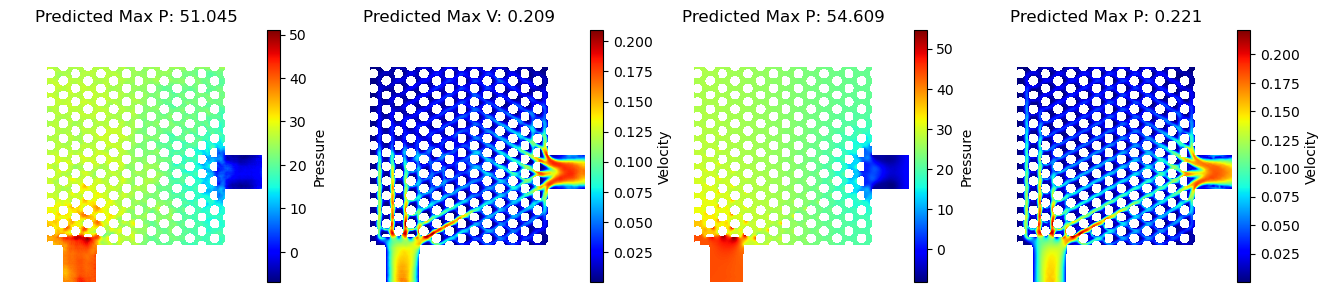

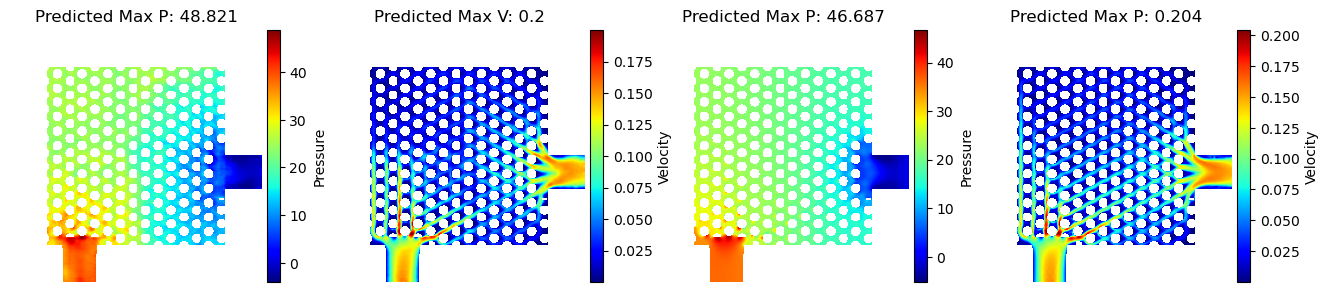

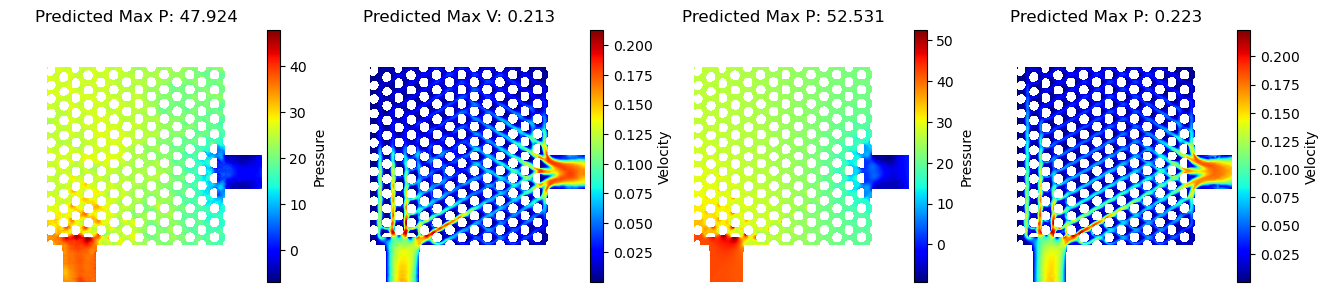

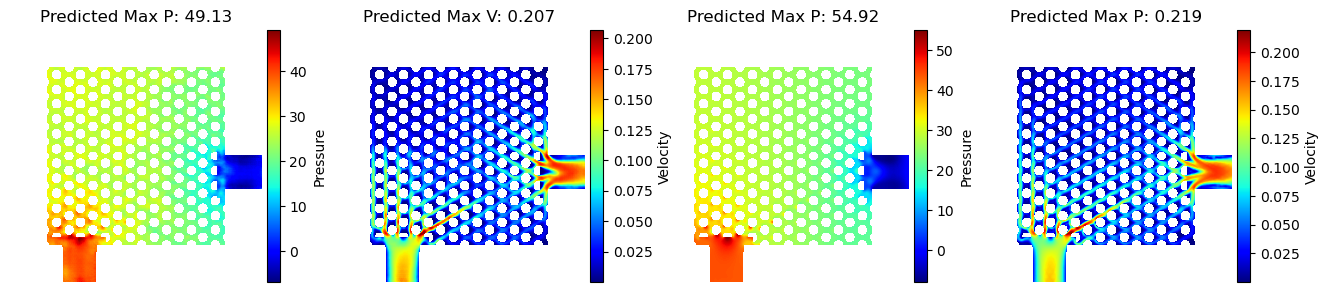

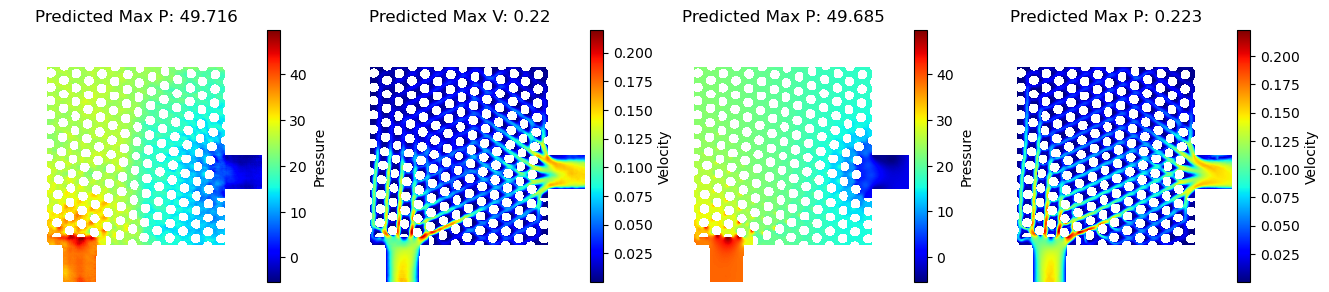

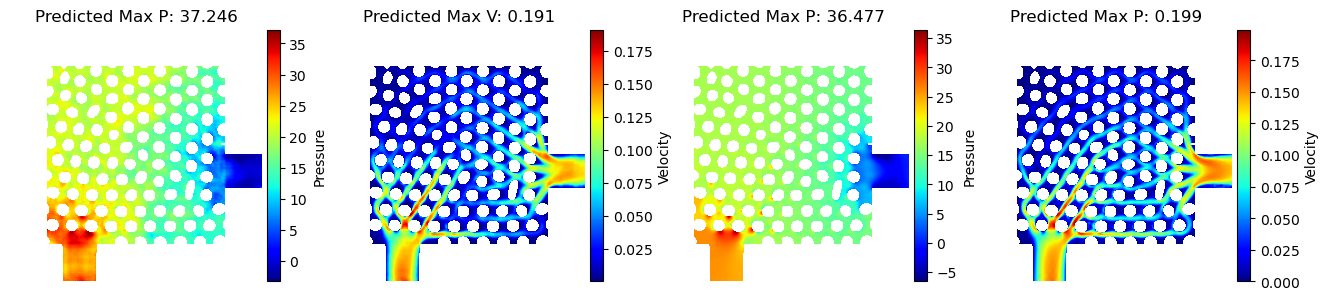

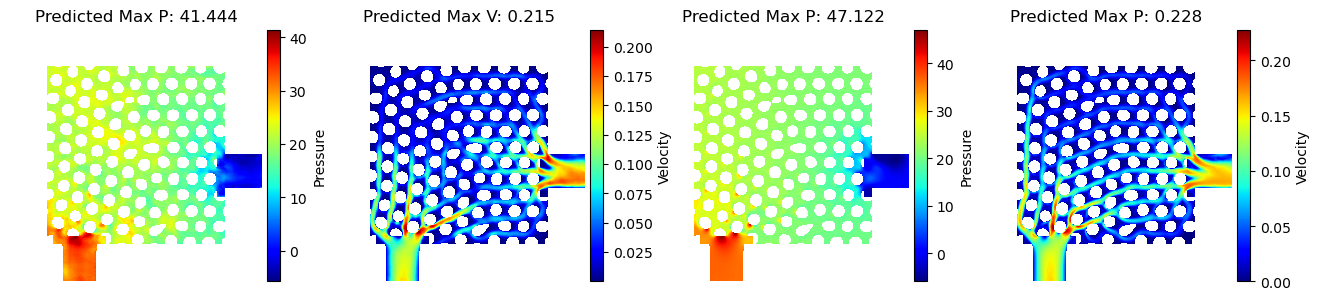

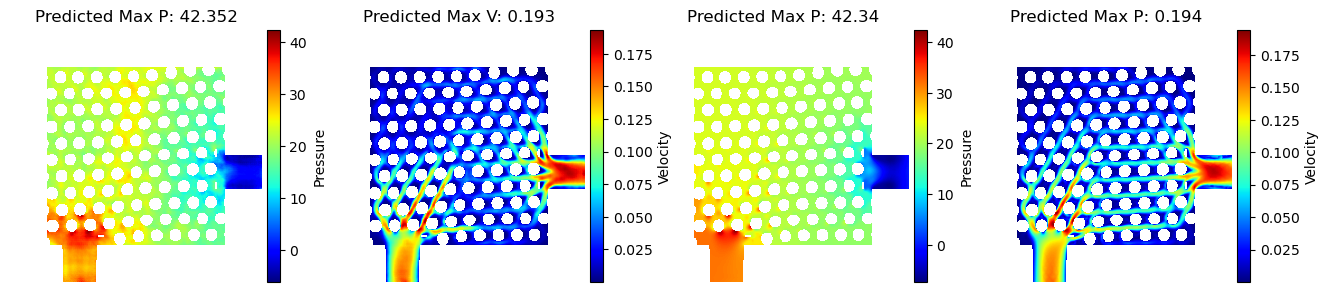

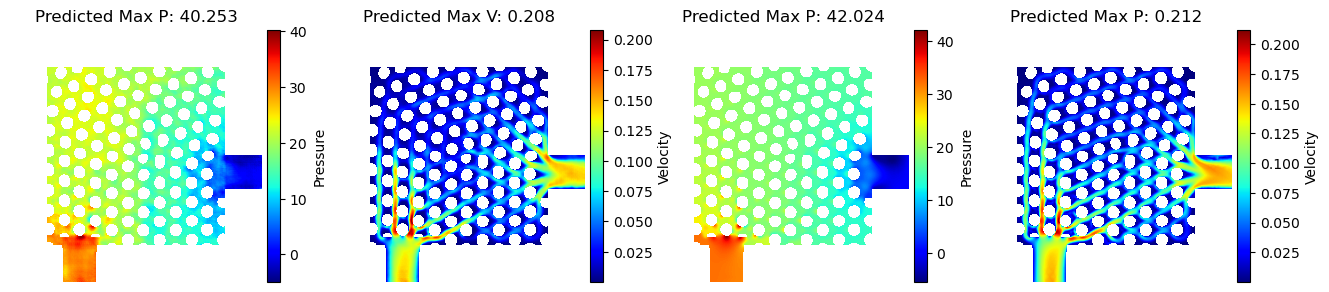

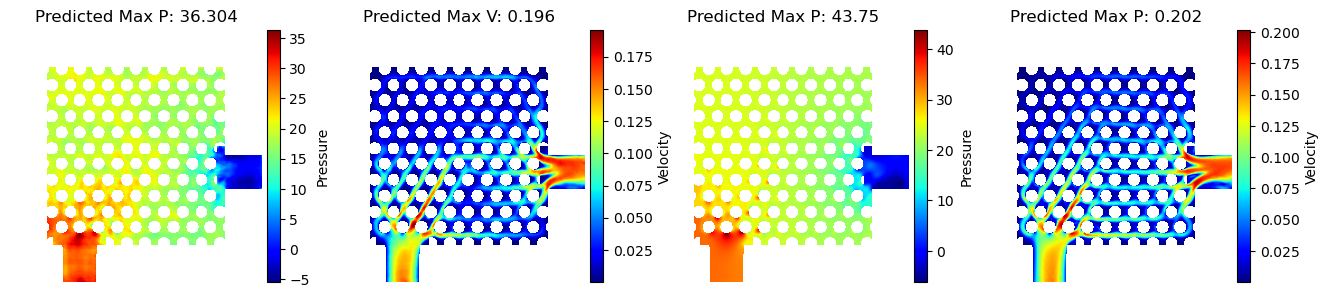

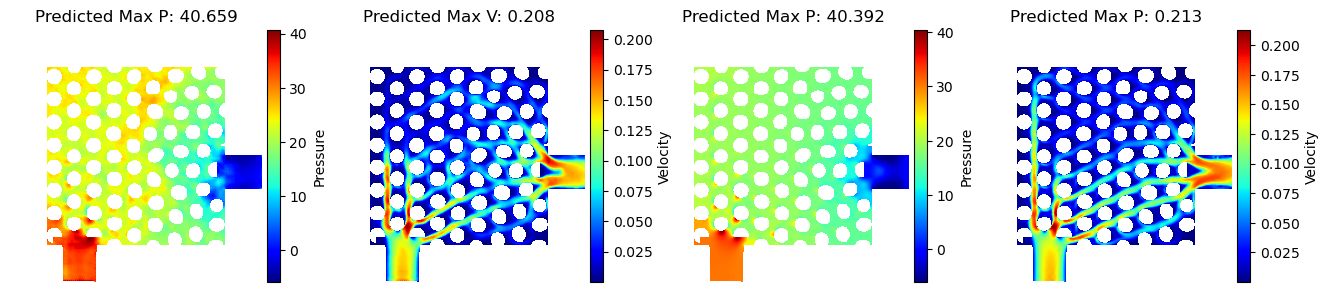

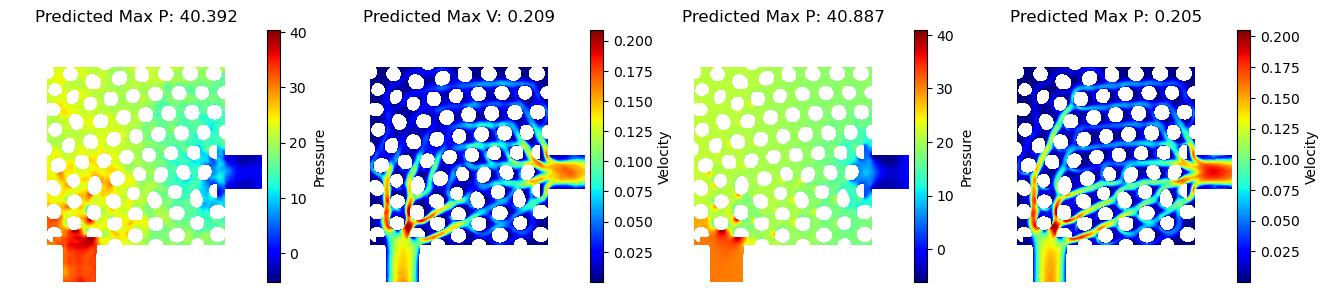

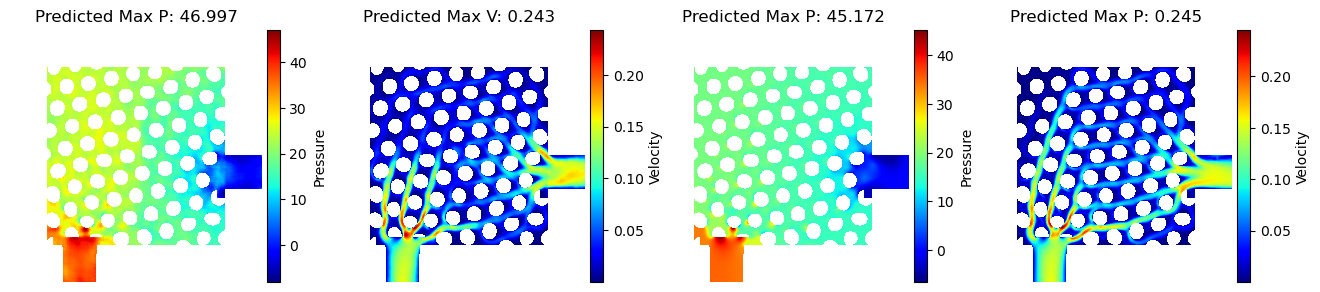

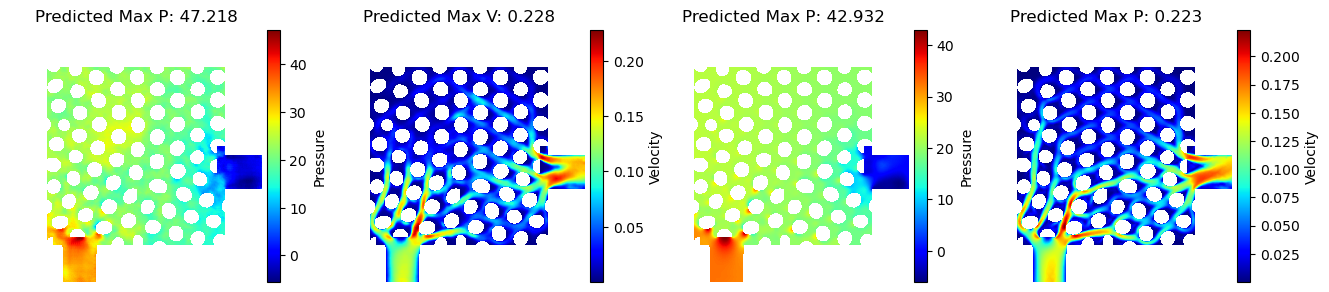

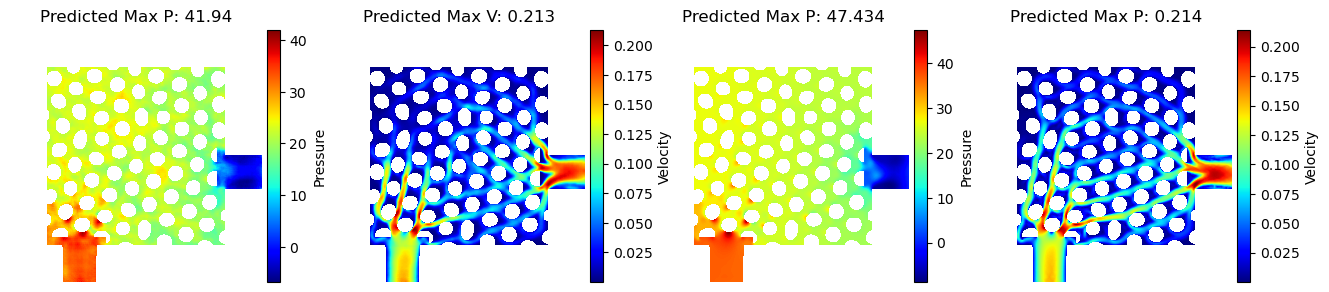

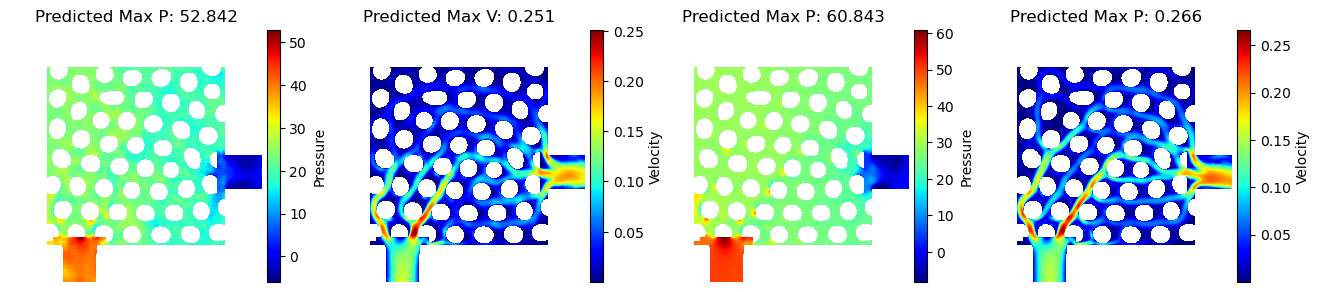

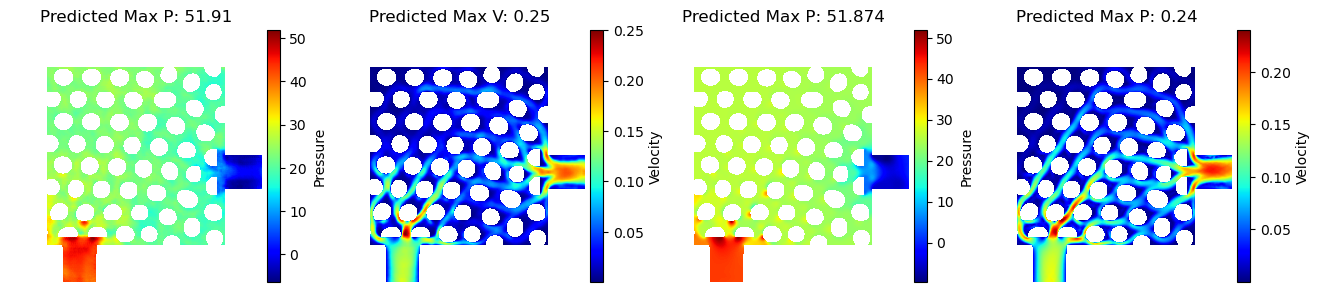

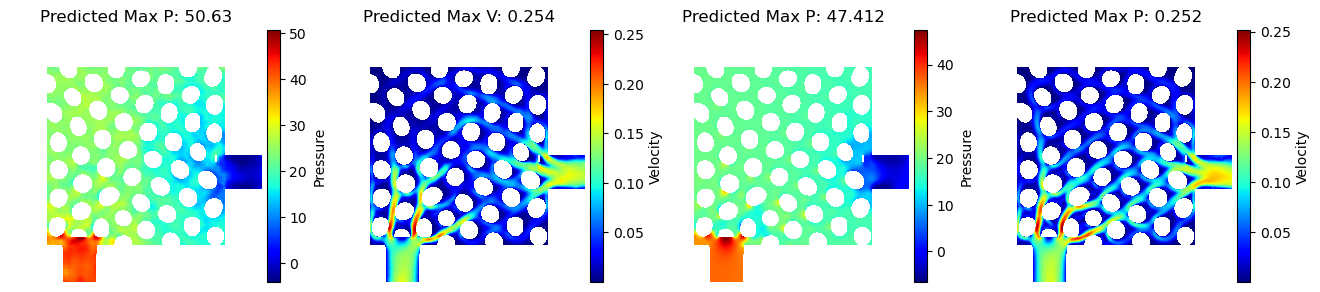

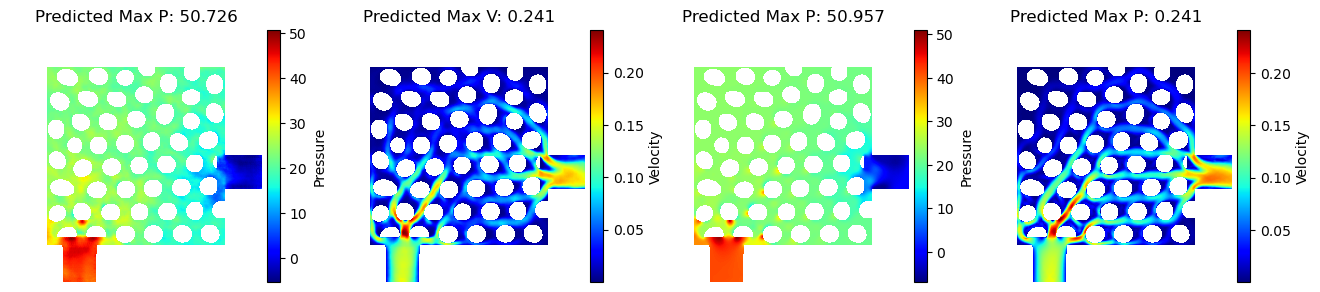

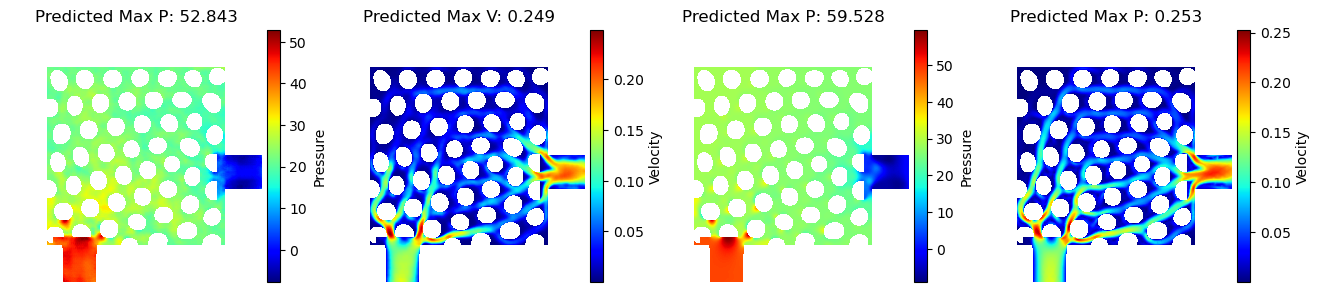

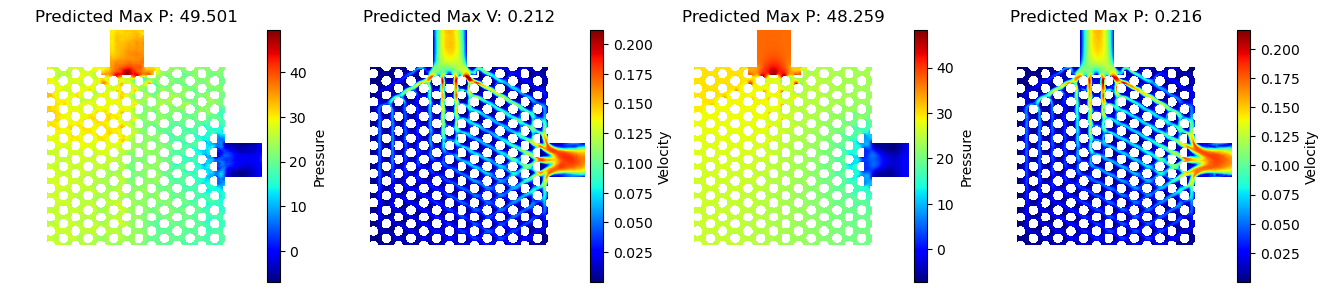

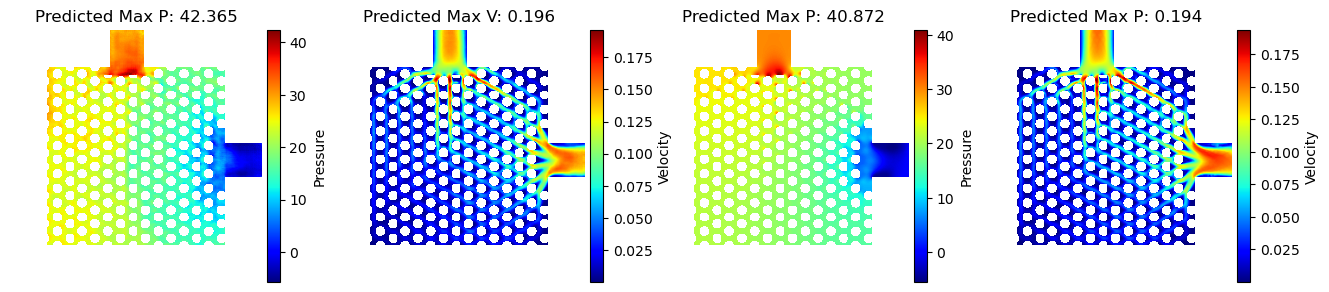

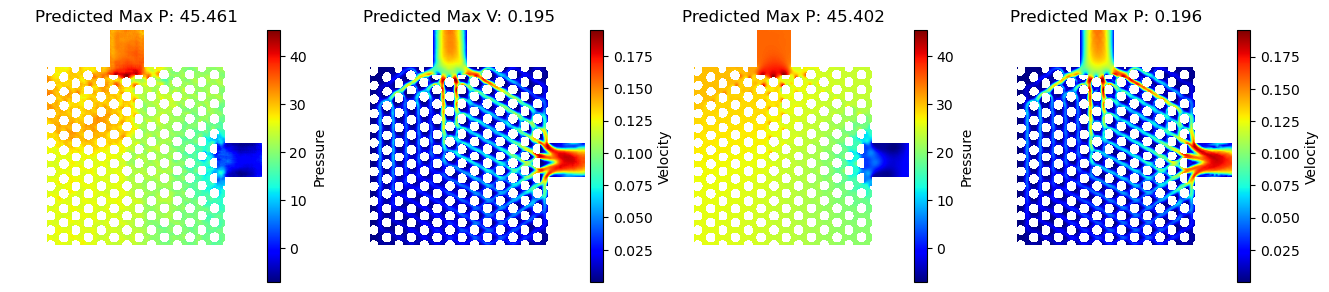

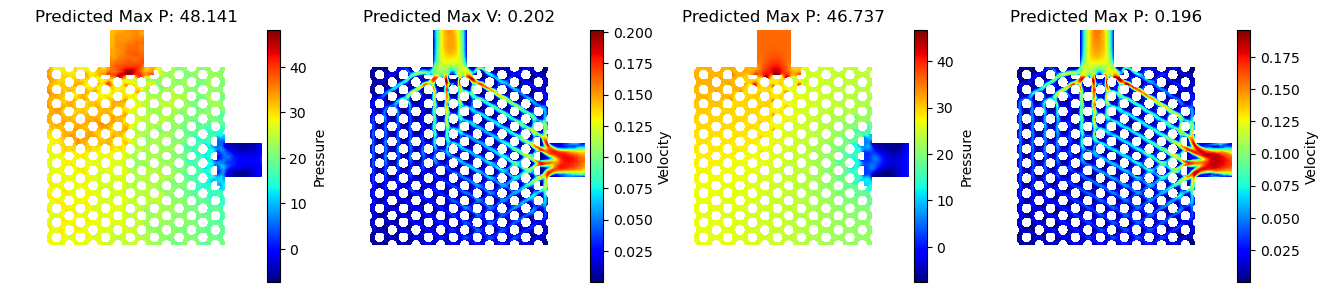

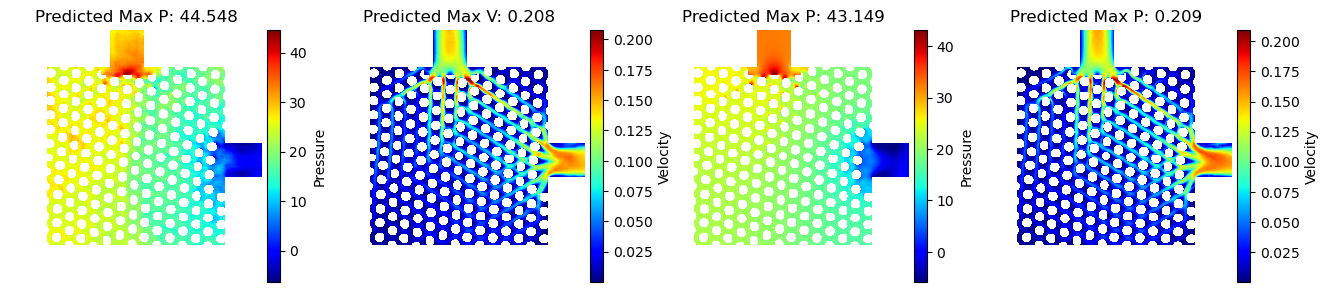

In [3]:
import matplotlib.pyplot as plt



hv2_folder = 'Validation/High/HVV'
hp2_folder = 'Validation/High/HPP'
lg2_folder = 'Validation/LG-3C2'

# Get the list of file names in each folder

hv2_files = [f2 for f2 in os.listdir(hv2_folder) if f2 != ".ipynb_checkpoints"]
hp2_files = [f2 for f2 in os.listdir(hp2_folder) if f2 != ".ipynb_checkpoints"]
lg2_files = [f2 for f2 in os.listdir(lg2_folder) if f2 != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
hv2_files.sort()
hp2_files.sort()
lg2_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images

# Create empty lists to store the data
X_lg2 = []
Y_hv2 = []
Y_hp2 = []

# Read the data from the folders
for hv2_file,hp2_file,lg2_file in zip( hv2_files,hp2_files,lg2_files):
    try:
        
        

        # Read the HFV
        hv2_image = np.load(os.path.join(hv2_folder, hv2_file))  # Convert to RGB
        Y_hv2.append(np.array(hv2_image))

    
    
        # Read the channel geometry image
        lg2_image = Image.open(os.path.join(lg2_folder, lg2_file)).convert('RGB')  # Convert to RGB
        lg2_image = lg2_image.resize(input_shape[:2])  # Resize the image
        X_lg2.append(np.array(lg2_image))
    
        # Read the HFP
        hp2_image = np.load(os.path.join(hp2_folder, hp2_file))  # Convert to RGB
        Y_hp2.append(np.array(hp2_image))
    except:
        print('')

# Convert the lists to arrays


X_lg2 = np.array(X_lg2) / 255.0  # Normalize the channel geometry images
Y_hv2 = np.array(Y_hv2)
Y_hp2 = np.array(Y_hp2)



model.load_weights('Saved_Models_Temp/total-Micro-Unet-Zero.h5')

pressure_output2,velocity_output2 = model.predict([X_lg2])

velocity_output2=(velocity_output2)
a=(np.max(Y_hp)-np.min(Y_hp))
b=(np.min(Y_hp))

pressure_output2=(pressure_output2*a)+b



mask = np.all(X_lg2 > 0.8, axis=-1)

# Expand mask to match the shape of array2
mask_expanded = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
Y_hp2[mask]=np.nan
Y_hv2[mask]=np.nan
velocity_output2[mask]=np.nan
pressure_output2[mask]=np.nan

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming pressure_output, velocity_output, Y_hp, and Y_hv are defined and loaded elsewhere




def plot_images(index):
    plt.figure(figsize=(16, 48))

    # Display the pressure output
    ax1 = plt.subplot(1, 4, 1)
    im1 = ax1.imshow(pressure_output2[index],cmap='jet')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1, label='Pressure')
    ax1.set_title('Predicted Max P: '+ str(np.round(np.nanmax(pressure_output2[index]),decimals=3)))
    ax1.axis("off")

    # Display the velocity output
    ax2 = plt.subplot(1, 4, 2)
    im2 = ax2.imshow(velocity_output2[index],cmap='jet')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2, label='Velocity')
    ax2.set_title('Predicted Max V: '+ str(np.round(np.nanmax(velocity_output2[index]),decimals=3)))
    ax2.axis("off")

    # Display the input image (Pressure GT)
    ax3 = plt.subplot(1, 4, 3)
    im3 = ax3.imshow(Y_hp2[index],cmap='jet')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3, label='Pressure')
    ax3.set_title('GT Max P: '+ str(np.round(np.nanmax(Y_hp2[index]),decimals=3)))
    ax3.axis("off")

    # Display the velocity GT
    ax4 = plt.subplot(1, 4, 4)
    im4 = ax4.imshow(Y_hv2[index],cmap='jet')
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4, label='Velocity')
    ax4.set_title('GT Max V: '+ str(np.round(np.nanmax(Y_hv2[index]),decimals=3)))
    ax4.axis("off")

    plt.show()

# Loop to plot images 
for i in range(0, 25):
    plot_images(i)

In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

Yp = np.expand_dims(Y_hp2, axis=-1)
Yv = np.expand_dims(Y_hv2, axis=-1)

expected = Yp
predicted = pressure_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 136.6820
MAE: 5.2745
RMSE: 11.6911
R^2: 0.7566
NRMSE: 0.0203
Relative Error: 1.2668
SMAPE: 29.5838%
Pearson Correlation: 0.8727
PSNR: 32.9519 dB


In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Dummy data (replace with actual predicted and expected arrays)
expected = Yv
predicted = velocity_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 0.00046651
MAE: 0.0127
RMSE: 0.0216
R^2: 0.8454
NRMSE: 0.0237
Relative Error: 537743530.4129
SMAPE: 55.4666%
Pearson Correlation: 0.9197
PSNR: 32.5123 dB


In [8]:
path1="Results_Temp/Mixed/Zero-Fidelity"
os.makedirs(path1, exist_ok=True)
np.save(path1+"/velocity_predicted.npy",velocity_output2)
np.save(path1+"/pressure_predicted.npy",pressure_output2)
